1 

Загрузите с сайта LIBSVM датасет real-sim. Загрузить датасет можно с помощью функции
load_svmlight_file из модуля sklearn.datasets.

In [1]:
from telepyth import TelepythClient

tp = TelepythClient()

Use token from .telepythrc.


In [2]:
import numpy as np
import json

In [3]:
from sklearn.datasets import load_svmlight_file

In [4]:
%time X, y = load_svmlight_file(f='real-sim.bz2')


CPU times: user 12.9 s, sys: 98.1 ms, total: 13 s
Wall time: 13.1 s


In [5]:
X

<72309x20958 sparse matrix of type '<class 'numpy.float64'>'
	with 3709083 stored elements in Compressed Sparse Row format>

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=241)

Сравните работу алгоритмов градиентного спуска и стохастического градиентного спуска для задачи логистической регрессии на этом датасете. Для алгоритма стохастического спуска сравните несколько начальных приближений между собой. Используйте следующие параметры для методов:
   
max_iter=10000, 

l2_coef=1e-5, 

tolerance=1e-5, 

step_alpha=1, 

step_beta=0, 

batch_size=1

Приведите следующие графики:


• Зависимость значения функции от реального времени работы метода


• Зависимость значения функции от итерации метода (эпохи в случае стохастического варианта) 

• Зависимость точности (accuracy) от реального времени работы метода

• Зависимость точности (accuracy) итерации метода (эпохи в случае стохастического варианта)

Сделайте выводы по проделанному эксперименту.

In [9]:
scaler = StandardScaler(with_mean=False)

In [10]:
#X_train = scaler.fit_transform(X_train)

In [11]:
#X_test = scaler.fit_transform(X_test)

batch_size = 2048

for i in range(0, X_train.shape[1], batch_size):
    if (i + batch_size) < X_train.shape[1]:
        X_train[:, i:i + batch_size] = scaler.fit_transform(X_train[:, i:i + batch_size])
    else:
        X_train[:, i:] = scaler.fit_transform(X_train[:, i:])

for i in range(0, X_test.shape[1], batch_size):
    if (i + batch_size) < X_test.shape[1]:
        X_test[:, i:i + batch_size] = scaler.fit_transform(X_test[:, i:i + batch_size])
    else:
        X_test[:, i:] = scaler.fit_transform(X_test[:, i:])

In [12]:
from scipy.sparse import hstack, csr_matrix

In [13]:
X_train = hstack([csr_matrix(np.ones((X_train.shape[0], 1))), X_train], format='csr')

In [14]:
X_test = hstack([csr_matrix(np.ones((X_test.shape[0], 1))), X_test], format='csr')

In [15]:
X_train.shape

(54231, 20959)

In [16]:
X_test.shape

(18078, 20959)

In [17]:
import numpy as np
import scipy
from scipy import sparse
from scipy.special import expit
from scipy.special import logsumexp


class BaseSmoothOracle:
    """
    Базовый класс для реализации оракулов.
    """
    def func(self, w):
        """
        Вычислить значение функции в точке w.
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, w):
        """
        Вычислить значение градиента функции в точке w.
        """
        raise NotImplementedError('Grad oracle is not implemented.')

        
class BinaryLogistic(BaseSmoothOracle):
    """
    Оракул для задачи двухклассовой логистической регрессии.
    
    Оракул должен поддерживать l2 регуляризацию.
    """
    
    def __init__(self, l2_coef=1e-5):
        """
        Задание параметров оракула.
        
        l2_coef - коэффициент l2 регуляризации
        """
        self.l2_coef = l2_coef
     
    def func(self, X, y, w):
        """
        Вычислить значение функционала в точке w на выборке X с ответами y.
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
        
        w - одномерный numpy array
        """
        
        block_size = 256

        loss = np.logaddexp(0, - y * X.dot(w)).sum()
        reg = self.l2_coef * 0.5 * (w ** 2).sum()
        return (1 / X.shape[0]) * loss + reg
        

    def grad(self, X, y, w):
        """
        Вычислить градиент функционала в точке w на выборке X с ответами y.
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
        
        w - одномерный numpy array
        """
        tmp = X.dot(w)
        tmp *= -y
        tmp = expit(tmp)
        tmp *= -y
        return X.transpose().dot(tmp).transpose() / y.shape[0] + self.l2_coef * w
    
    
class MulticlassLogistic(BaseSmoothOracle):
    """
    Оракул для задачи многоклассовой логистической регрессии.
    
    Оракул должен поддерживать l2 регуляризацию.
    
    w в этом случае двумерный numpy array размера (class_number, d),
    где class_number - количество классов в задаче, d - размерность задачи
    """
    
    def __init__(self, class_number=None, l2_coef=1):
        """
        Задание параметров оракула.
        
        class_number - количество классов в задаче
        
        l2_coef - коэффициент l2 регуляризации
        """
        self.class_number = class_number
        self.l2_coef = l2_coef
     
    def func(self, X, y, w):
        """
        Вычислить значение функционала в точке w на выборке X с ответами y.
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
        
        w - двумерный numpy array
        """
        if self.class_number is None:
            self.class_number = w.shape[0]

        first_for_loss = - X.dot(w.transpose())[np.arange(X.shape[0]), y].sum()
        #%time first_for_loss = - X.dot(w.transpose())[np.arange(X.shape[0]), y].sum()

        sum_for_loss = logsumexp(X.dot(w.transpose()).transpose(), axis=0).sum()
        #%time sum_for_loss = logsumexp(X.dot(w.transpose()).transpose(), axis=0).sum()
        
        loss = (1 / X.shape[0]) * (sum_for_loss + first_for_loss)
        #%time loss = (1 / X.shape[0]) * (sum_for_loss + first_for_loss)

        reg = self.l2_coef * 0.5 * (w ** 2).sum()
        #%time reg = self.l2_coef * 0.5 * (w ** 2).sum()

        return loss + reg
        
    def grad(self, X, y, w):
        """
        Вычислить значение функционала в точке w на выборке X с ответами y.
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
        
        w - двумерный numpy array
        """
        if self.class_number is None:
            self.class_number = w.shape[0]
        mask = y[np.newaxis, :] == np.arange(self.class_number)[:, np.newaxis]
            
        first_sum = (X.transpose().dot(mask.transpose())).transpose()
        
        a_max = X.dot(w.transpose()).max(axis=1)[:, np.newaxis]

        tmp_h = np.exp(X.dot(w.transpose()) - a_max)

        tmp_l = (np.exp(X.dot(w.transpose()) - a_max)).sum(axis=1)

        tmp_next = X.transpose().dot(tmp_h / tmp_l[:, np.newaxis]).transpose()
        return - (first_sum - tmp_next) / X.shape[0] + self.l2_coef * w

In [20]:
import numpy as np
from random import randint, sample
import timeit
from scipy.special import expit
from numpy.linalg import norm
from sklearn.metrics import accuracy_score

class GDClassifier:
    """
    Реализация метода градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """
    def __init__(self, loss_function, step_alpha=1, step_beta=0, 
                 tolerance=1e-5, max_iter=10000, **kwargs):
        """
        loss_function - строка, отвечающая за функцию потерь классификатора. 
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия
        - 'multinomial_logistic' - многоклассовая логистическая регрессия
                
        step_alpha - float, параметр выбора шага из текста задания
        
        step_beta- float, параметр выбора шага из текста задания
        
        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию.
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если (f(x_{k+1}) - f(x_{k})) < tolerance: то выход 
        
        max_iter - максимальное число итераций     
        
        **kwargs - аргументы, необходимые для инициализации   
        """
        self.loss_function = loss_function
        if loss_function == 'binary_logistic':
            self.oracle = BinaryLogistic(**kwargs)
        else:
            self.oracle = MulticlassLogistic(**kwargs)
        
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w = None
        
    def fit(self, X, y, w_0=None, trace=False, X_test=None, y_test=None):
        """
        Обучение метода по выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
        
        w_0 - начальное приближение в методе
        
        trace - переменная типа bool
      
        Если trace = True, то метод должен вернуть словарь history, содержащий информацию 
        о поведении метода. Длина словаря history = количество итераций + 1 (начальное приближение)
        
        history['time']: list of floats, содержит интервалы времени между двумя итерациями метода
        history['func']: list of floats, содержит значения функции на каждой итерации
        (0 для самой первой точки)
        """
        history = {'time': [], 'func': [0], 'cum_time': [], 'accuracy': []}

        self.w = w_0

        if self.w is None:
            if self.loss_function == 'binary_logistic':
                self.w = np.zeros(X.shape[1], dtype=float)
            else:
                self.w = np.zeros((np.unique(y).shape[0], X.shape[1]), dtype=float)
        count = 1
        
        
        grad = self.get_gradient(X, y)

        eta = self.step_alpha * (count ** -self.step_beta)

        w_next = self.w - eta * grad
        
        tol = self.tolerance

        history['func'].append(self.get_objective(X, y))

        while (abs(history['func'][-2] - history['func'][-1]) >= tol) and (count <= self.max_iter):
            #print(count)
            
            start_time = timeit.default_timer()
            
            self.w = w_next.copy()
            if not (X_test is None):
                y_pred = self.predict(X_test)
                #print(accuracy_score(y_true=y_test, y_pred=y_pred))
                history['accuracy'].append(accuracy_score(y_true=y_test, y_pred=y_pred))
            
            grad = self.get_gradient(X, y)
            count += 1

            eta = self.step_alpha * (count ** -self.step_beta)

            w_next -= eta * grad
            
            history['func'].append(self.get_objective(X, y))
            history['time'].append(timeit.default_timer() - start_time)

        if trace:
            history['cum_time'] = np.cumsum(history['time'])
            history['func'] = history['func'][1:]
            return history

    def predict(self, X):
        """
        Получение меток ответов на выборке X
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        return: одномерный numpy array с предсказаниями
        """
        if self.w is None:
            raise Exception('Not trained yet')
        if self.loss_function == 'binary_logistic':
            res = self.predict_proba(X).argmax(axis=1)
            res[res == 0] = -1
            return res
        else:
            return self.predict_proba(X).argmax(axis=1)

    def predict_proba(self, X):
        """
        Получение вероятностей принадлежности X к классу k
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        return: двумерной numpy array, [i, k] значение соответветствует вероятности
        принадлежности i-го объекта к классу k 
        """
        if self.w is None:
            raise Exception('Not trained yet')
        if self.loss_function == 'binary_logistic':
            res = expit(X.dot(self.w))
            return np.vstack((1 - res, res)).transpose()
        else:
            a_max = X.dot(self.w.transpose()).max(axis=1)[:, np.newaxis]
            tmp_h = np.exp(X.dot(self.w.transpose()) - a_max)
            tmp_l = (np.exp(X.dot(self.w.transpose()) - a_max)).sum(axis=1)
            
            return tmp_h / tmp_l[:, np.newaxis]



    def get_objective(self, X, y):
        """
        Получение значения целевой функции на выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        
        return: float
        """
        if self.w is None:
            raise Exception('Not trained yet')
        return self.oracle.func(X, y, self.w)
        
    def get_gradient(self, X, y):
        """
        Получение значения градиента функции на выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        
        return: numpy array, размерность зависит от задачи
        """
        if self.w is None:
            raise Exception('Not trained yet')
        
        return self.oracle.grad(X, y, self.w)
    
    def get_weights(self):
        """
        Получение значения весов функционала
        """
        if self.w is None:
            raise Exception('Not trained yet')
        return self.w 

    
class SGDClassifier(GDClassifier):
    """
    Реализация метода стохастического градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """
    
    def __init__(self, loss_function, batch_size=1, step_alpha=1, step_beta=0, 
                 tolerance=1e-5, max_iter=10000, random_seed=153, **kwargs):
        """
        loss_function - строка, отвечающая за функцию потерь классификатора. 
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия
        - 'multinomial_logistic' - многоклассовая логистическая регрессия
        
        batch_size - размер подвыборки, по которой считается градиент
        
        step_alpha - float, параметр выбора шага из текста задания
        
        step_beta- float, параметр выбора шага из текста задания
        
        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если (f(x_{k+1}) - f(x_{k})) < tolerance: то выход 
        
        
        max_iter - максимальное число итераций
        
        random_seed - в начале метода fit необходимо вызвать np.random.seed(random_seed).
        Этот параметр нужен для воспроизводимости результатов на разных машинах.
        
        **kwargs - аргументы, необходимые для инициализации
        """
        lf = loss_function
        super().__init__(lf, step_alpha, step_beta, tolerance, max_iter, **kwargs)

        self.batch_size = batch_size
        self.random_seed = random_seed

    def fit(self, X, y, w_0=None, trace=False, log_freq=1, X_test=None, y_test=None):
        """
        Обучение метода по выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
                
        w_0 - начальное приближение в методе
        
        Если trace = True, то метод должен вернуть словарь history, содержащий информацию 
        о поведении метода. Если обновлять history после каждой итерации, метод перестанет 
        превосходить в скорости метод GD. Поэтому, необходимо обновлять историю метода лишь
        после некоторого числа обработанных объектов в зависимости от приближённого номера эпохи.
        Приближённый номер эпохи:
            {количество объектов, обработанных методом SGD} / {количество объектов в выборке}
        
        log_freq - float от 0 до 1, параметр, отвечающий за частоту обновления. 
        Обновление должно проиходить каждый раз, когда разница между двумя значениями 
        приближённого номера эпохи
        будет превосходить log_freq.
        
        history['epoch_num']: list of floats, в каждом элементе списка будет 
        записан приближённый номер эпохи:
        history['time']: list of floats, содержит интервалы времени между 
        двумя соседними замерами
        history['func']: list of floats, содержит значения функции после 
        текущего приближённого номера эпохи
        history['weights_diff']: list of floats, содержит квадрат нормы 
        разности векторов весов с соседних замеров
        (0 для самой первой точки)
        """
        np.random.seed(self.random_seed)

        history = {'epoch_num': [], 
                        'time': [], 
                        'func': [0], 
                        'weights_diff': [0], 
                        'cum_time': [], 
                        'accuracy': []}

        self.w = w_0
        
        if self.w is None:
            if self.loss_function == 'binary_logistic':
                self.w = np.zeros(X.shape[1], dtype=float)
            else:
                self.w = np.zeros((np.unique(y).shape[0], X.shape[1]), dtype=float)

        count = 1

        
        indexes = np.random.permutation(X.shape[0])[:self.batch_size]

        grad = self.get_gradient(X[indexes], y[indexes])
        
        eta = self.step_alpha * (count ** -self.step_beta)

        w_next = self.w - eta * grad
        
        tol = self.tolerance
        
        history['epoch_num'].append(count * self.batch_size // X.shape[0])
        prev_func = 0
        curr_func = self.get_objective(X, y)
        
        history['func'].append(curr_func)

        set_timer = True

        while (abs(prev_func - curr_func) >= tol) and (count <= self.max_iter):
            if set_timer:
                start_time = timeit.default_timer()
                set_timer = False

            self.w = w_next.copy()
            indexes = np.random.permutation(X.shape[0])[:self.batch_size]

            grad = self.get_gradient(X[indexes], y[indexes])

            count += 1

            eta = self.step_alpha * (count ** -self.step_beta)

            w_next -= eta * grad
            
            if(count * self.batch_size > X.shape[0] * (log_freq + history['epoch_num'][-1]) + 1):
                if not (X_test is None):
                    y_pred = self.predict(X_test)
                    history['accuracy'].append(accuracy_score(y_true=y_test, y_pred=y_pred))
                
                history['epoch_num'].append((count * self.batch_size + 1) / X.shape[0])
                history['func'].append(self.get_objective(X, y))
                history['time'].append(timeit.default_timer() - start_time)
                set_timer = True
            prev_func = curr_func
            curr_func = self.get_objective(X, y)
        
        if trace:
            history['cum_time'] = np.cumsum(history['time'])
            history['func'] = history['func'][1:]
            return history


In [294]:
gdc_classifier = GDClassifier(loss_function='binary_logistic')

In [295]:
tp.send_text('full start')

%time gdc_history = gdc_classifier.fit(X=X_train, y=y_train, X_test=X_test, y_test=y_test, trace=True)

tp.send_text('full end')

0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.687631375152
0.68763137

0.79560792123
0.795718552937
0.795939816351
0.796161079765
0.796658922447
0.796880185861
0.796935501715
0.797101449275
0.79748866025
0.797654607811
0.797986502932
0.798318398053
0.798760924881
0.799092820002
0.79936939927
0.799590662684
0.799756610244
0.800033189512
0.800199137073
0.80030976878
0.800586348047
0.800696979754
0.800807611461
0.801028874876
0.80125013829
0.801471401704
0.801747980971
0.802024560239
0.802079876092
0.80235645536
0.802688350481
0.803130877309
0.803352140724
0.803628719991
0.804071246819
0.804624405355
0.804900984622
0.805066932183
0.805232879743
0.805564774864
0.805786038279
0.805841354132
0.806007301693
0.806062617546
0.80628388096
0.806449828521
0.806837039496
0.807113618763
0.807279566324
0.807500829738
0.807832724859
0.808275251687
0.808662462662
0.808828410222
0.809049673636
0.809381568758
0.809602832172
0.809879411439
0.810100674853
0.810377254121
0.810764465096
0.811096360217
0.81115167607
0.811372939484
0.811815466313
0.811981413873
0.81209204558
0.81

0.865527160084
0.865582475938
0.865693107645
0.865637791791
0.865859055205
0.865914371059
0.866080318619
0.866135634473
0.86624626618
0.86624626618
0.866301582033
0.866356897887
0.866522845448
0.866522845448
0.866522845448
0.866578161301
0.866633477155
0.866744108862
0.866799424715
0.866799424715
0.866965372276
0.867076003983
0.867076003983
0.867131319836
0.867297267397
0.867463214957
0.867573846664
0.867629162518
0.867739794225
0.867739794225
0.867795110079
0.867850425932
0.867961057639
0.868071689346
0.868182321053
0.868237636907
0.868237636907
0.868403584467
0.868458900321
0.868569532028
0.868735479588
0.868846111295
0.868956743003
0.869012058856
0.86906737471
0.869012058856
0.869012058856
0.86906737471
0.869122690563
0.869288638124
0.869399269831
0.869399269831
0.869399269831
0.869454585684
0.869509901538
0.869509901538
0.869565217391
0.869620533245
0.869731164952
0.869675849098
0.869841796659
0.869897112512
0.870007744219
0.870007744219
0.870118375927
0.87017369178
0.870284323487


0.89639340635
0.89639340635
0.89639340635
0.896448722204
0.896504038057
0.896559353911
0.896614669764
0.896614669764
0.896614669764
0.896614669764
0.896614669764
0.896614669764
0.896669985618
0.896669985618
0.896835933178
0.896835933178
0.896891249032
0.896891249032
0.896891249032
0.897001880739
0.897057196593
0.897112512446
0.8971678283
0.8971678283
0.8971678283
0.897223144153
0.897278460007
0.89733377586
0.897389091714
0.897389091714
0.897389091714
0.897389091714
0.897444407567
0.897444407567
0.897555039274
0.897555039274
0.897555039274
0.897555039274
0.897555039274
0.897555039274
0.897610355128
0.897776302688
0.897776302688
0.897831618542
0.897831618542
0.897831618542
0.897831618542
0.897886934395
0.897886934395
0.897942250249
0.897997566102
0.898108197809
0.898108197809
0.898108197809
0.898108197809
0.898108197809
0.898218829517
0.89827414537
0.89827414537
0.898329461224
0.898440092931
0.898495408784
0.898495408784
0.898550724638
0.898550724638
0.898550724638
0.898495408784
0.89860

0.91099679168
0.91099679168
0.91099679168
0.91099679168
0.911052107534
0.911052107534
0.911052107534
0.911052107534
0.911107423388
0.911162739241
0.911162739241
0.911218055095
0.911218055095
0.911273370948
0.911328686802
0.911328686802
0.911328686802
0.911328686802
0.911384002655
0.911384002655
0.911328686802
0.911328686802
0.911328686802
0.911328686802
0.911328686802
0.911328686802
0.911328686802
0.911328686802
0.911384002655
0.911384002655
0.911384002655
0.911439318509
0.911439318509
0.911439318509
0.911439318509
0.911439318509
0.911439318509
0.911439318509
0.911439318509
0.911439318509
0.911439318509
0.911439318509
0.911494634362
0.911494634362
0.911494634362
0.911660581923
0.911715897776
0.91177121363
0.911826529483
0.911881845337
0.911881845337
0.911881845337
0.911881845337
0.911881845337
0.911992477044
0.911992477044
0.911992477044
0.912047792897
0.912047792897
0.912047792897
0.912047792897
0.912047792897
0.912103108751
0.912158424604
0.912158424604
0.912158424604
0.912158424604


0.920898329461
0.920898329461
0.920898329461
0.920898329461
0.920953645315
0.920953645315
0.921008961168
0.921008961168
0.921008961168
0.921119592875
0.921119592875
0.921119592875
0.921119592875
0.921119592875
0.921119592875
0.921119592875
0.921119592875
0.921119592875
0.921119592875
0.921119592875
0.921119592875
0.921119592875
0.921119592875
0.921174908729
0.921174908729
0.921174908729
0.921174908729
0.921230224582
0.921230224582
0.921285540436
0.921285540436
0.921340856289
0.921340856289
0.921396172143
0.921451487996
0.921451487996
0.921451487996
0.921451487996
0.921451487996
0.921451487996
0.92150680385
0.92150680385
0.92150680385
0.92150680385
0.92150680385
0.92150680385
0.921617435557
0.921672751411
0.921672751411
0.921728067264
0.921728067264
0.921783383118
0.921783383118
0.921783383118
0.921838698971
0.921949330678
0.921949330678
0.921949330678
0.922004646532
0.922004646532
0.922004646532
0.921949330678
0.921949330678
0.922004646532
0.922004646532
0.922059962385
0.922059962385
0

0.928808496515
0.928808496515
0.928808496515
0.928808496515
0.928753180662
0.928753180662
0.928808496515
0.928808496515
0.928808496515
0.928808496515
0.928808496515
0.928808496515
0.928808496515
0.928808496515
0.928808496515
0.928808496515
0.928808496515
0.928808496515
0.928808496515
0.928863812369
0.928919128222
0.928919128222
0.928919128222
0.928919128222
0.928919128222
0.928919128222
0.928919128222
0.928919128222
0.928919128222
0.928919128222
0.928919128222
0.928974444076
0.928974444076
0.928974444076
0.928974444076
0.928974444076
0.928974444076
0.928974444076
0.928974444076
0.928974444076
0.928974444076
0.928974444076
0.928974444076
0.928974444076
0.928974444076
0.928974444076
0.928974444076
0.928974444076
0.928974444076
0.928974444076
0.928974444076
0.929029759929
0.929029759929
0.929029759929
0.929029759929
0.929029759929
0.929029759929
0.929029759929
0.929029759929
0.929029759929
0.929029759929
0.929029759929
0.929029759929
0.929029759929
0.929029759929
0.929029759929
0.92902975

0.932680606262
0.932680606262
0.932680606262
0.932680606262
0.932680606262
0.932680606262
0.932680606262
0.932680606262
0.932680606262
0.932680606262
0.932791237969
0.932846553822
0.932901869676
0.932901869676
0.932901869676
0.932957185529
0.932957185529
0.932957185529
0.932957185529
0.932957185529
0.933012501383
0.933012501383
0.933012501383
0.933067817236
0.933067817236
0.933067817236
0.933067817236
0.933067817236
0.933067817236
0.933067817236
0.933067817236
0.933067817236
0.933067817236
0.933067817236
0.933067817236
0.933067817236
0.933067817236
0.933067817236
0.933067817236
0.93312313309
0.93312313309
0.93312313309
0.93312313309
0.933178448943
0.933178448943
0.933178448943
0.933233764797
0.933233764797
0.933233764797
0.933233764797
0.933233764797
0.933233764797
0.933233764797
0.933233764797
0.933233764797
0.933233764797
0.933233764797
0.933233764797
0.933233764797
0.933233764797
0.933233764797
0.933289080651
0.933289080651
0.933289080651
0.933289080651
0.933289080651
0.933289080651

0.937493085518
0.937548401372
0.937548401372
0.937659033079
0.937659033079
0.937659033079
0.937659033079
0.937659033079
0.937659033079
0.937659033079
0.937659033079
0.937659033079
0.937659033079
0.937659033079
0.937659033079
0.937659033079
0.937714348932
0.937714348932
0.937714348932
0.937714348932
0.937714348932
0.937714348932
0.937714348932
0.937769664786
0.937769664786
0.937769664786
0.937769664786
0.937769664786
0.937769664786
0.937769664786
0.937769664786
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937824980639
0.937880296493
0.937880296493
0.937880296493
0.93788029

0.94097798429
0.94097798429
0.94097798429
0.94097798429
0.941033300144
0.941033300144
0.941033300144
0.941033300144
0.941088615997
0.941143931851
0.941199247704
0.941199247704
0.941199247704
0.941254563558
0.941254563558
0.941254563558
0.941254563558
0.941254563558
0.941254563558
0.941254563558
0.941309879411
0.941309879411
0.941309879411
0.941309879411
0.941309879411
0.941309879411
0.941309879411
0.941309879411
0.941309879411
0.941309879411
0.941309879411
0.941309879411
0.941365195265
0.941365195265
0.941365195265
0.941365195265
0.941365195265
0.941365195265
0.941420511118
0.941365195265
0.941365195265
0.941420511118
0.941420511118
0.941420511118
0.941420511118
0.941420511118
0.941420511118
0.941420511118
0.941420511118
0.941420511118
0.941420511118
0.941475826972
0.941475826972
0.941531142826
0.941586458679
0.941641774533
0.941641774533
0.941641774533
0.941641774533
0.941641774533
0.941641774533
0.941641774533
0.941641774533
0.941641774533
0.941641774533
0.941641774533
0.941641774533

0.944352251355
0.944352251355
0.944352251355
0.944352251355
0.944352251355
0.944352251355
0.944352251355
0.944407567209
0.944407567209
0.944407567209
0.944407567209
0.944407567209
0.944407567209
0.944407567209
0.944462883062
0.944462883062
0.944462883062
0.944462883062
0.944462883062
0.944462883062
0.944462883062
0.944462883062
0.944462883062
0.944462883062
0.944462883062
0.944518198916
0.944518198916
0.944518198916
0.944518198916
0.944518198916
0.944518198916
0.944518198916
0.944518198916
0.944518198916
0.944518198916
0.944518198916
0.944518198916
0.944518198916
0.944573514769
0.944628830623
0.944628830623
0.944628830623
0.944684146476
0.944684146476
0.944684146476
0.944684146476
0.944684146476
0.944684146476
0.944684146476
0.94473946233
0.94473946233
0.94473946233
0.94473946233
0.94473946233
0.94473946233
0.94473946233
0.94473946233
0.94473946233
0.94473946233
0.94473946233
0.94473946233
0.94473946233
0.94473946233
0.94473946233
0.94473946233
0.944794778183
0.944794778183
0.944794778

200

In [ ]:
tp.send_text('end')

In [296]:
gdc_history['cum_time'] = list(gdc_history['cum_time'])

In [126]:


output=open("full_history_out_tolerance_10-3.txt", "w")

json.dump(gdc_history, output)

output.close()

Разные начальные приближения для стохастического спуска

In [427]:
sgdc_classifier = SGDClassifier(loss_function='binary_logistic', max_iter=10000, tolerance=1e-6)

In [428]:
tp.send_text('stochastic 0 start')

%time sgdc_history_0 = sgdc_classifier.fit(X=X_train, \
                                              y=y_train, \
                                              X_test=X_test, \
                                              y_test=y_test, \
                                              w_0=np.zeros(X_train.shape[1]), \
                                            log_freq=0.001, \
                                              trace=True)

tp.send_text('stochastic 0 end')

sgdc_history_0['cum_time'] = list(sgdc_history_0['cum_time'])

output=open("stochastic_0_history_out.txt", "w")

json.dump(sgdc_history_0, output)

output.close()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [430]:
sgdc_history_0['epoch_num']

[0,
 0.0010510593571942247,
 0.0021021187143884495,
 0.0031531780715826742,
 0.004204237428776899,
 0.005255296785971124,
 0.0063063561431653484,
 0.007357415500359573,
 0.008408474857553798,
 0.009459534214748022,
 0.010510593571942247,
 0.011561652929136471,
 0.012612712286330697,
 0.01366377164352492,
 0.014714831000719146,
 0.01576589035791337,
 0.016816949715107596,
 0.01786800907230182,
 0.018919068429496044,
 0.01997012778669027,
 0.021021187143884495,
 0.02207224650107872,
 0.023123305858272943,
 0.024174365215467168,
 0.025225424572661394,
 0.02627648392985562,
 0.02732754328704984,
 0.028378602644244067]

In [432]:
tp.send_text('stochastic 1 start')

%time sgdc_history_1 = sgdc_classifier.fit(X=X_train, \
                                           y=y_train, \
                                            X_test=X_test, \
                                            y_test=y_test, \
                                            w_0=np.ones(X_train.shape[1]), \
                                           log_freq=0.001, \
                                            trace=True)

tp.send_text('stochastic 1 end')

sgdc_history_1['cum_time'] = list(sgdc_history_1['cum_time'])

output=open("stochastic_1_history_out.txt", "w")

json.dump(sgdc_history_1, output)

output.close()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082


In [433]:
tp.send_text('stochastic 0.75 start')

%time sgdc_history_075 = sgdc_classifier.fit(X=X_train, \
                                              y=y_train, \
                                              X_test=X_test, \
                                              y_test=y_test, \
                                              w_0=0.75 * np.ones(X_train.shape[1]), \
                                             log_freq=0.001, \
                                              trace=True)

tp.send_text('stochastic 0.75 end')

sgdc_history_075['cum_time'] = list(sgdc_history_075['cum_time'])

output=open("stochastic_075_history_out.txt", "w")

json.dump(sgdc_history_075, output)

output.close()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


In [434]:
tp.send_text('stochastic 0.5 start')

%time sgdc_history_050 = sgdc_classifier.fit(X=X_train, \
                                              y=y_train, \
                                              X_test=X_test, \
                                              y_test=y_test, \
                                              w_0=0.5 * np.ones(X_train.shape[1]), \
                                             log_freq=0.001, \
                                              trace=True)
tp.send_text('stochastic 0.5 end')

sgdc_history_050['cum_time'] = list(sgdc_history_050['cum_time'])

output=open("stochastic_050_history_out.txt", "w")

json.dump(sgdc_history_050, output)

output.close()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
CPU times: user 16.8 s, sys: 588 ms, total: 17.3 s
Wall time: 17.8 s


In [435]:
tp.send_text('stochastic 0.25 start')

%time sgdc_history_025 = sgdc_classifier.fit(X=X_train, \
                                              y=y_train, \
                                              X_test=X_test, \
                                              y_test=y_test, \
                                              w_0=0.25 * np.ones(X_train.shape[1]), \
                                             log_freq=0.001, \
                                              trace=True)

tp.send_text('stochastic 0.25 end')

sgdc_history_025['cum_time'] = list(sgdc_history_025['cum_time'])

output=open("stochastic_025_history_out.txt", "w")

json.dump(sgdc_history_025, output)

output.close()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079


In [303]:
output=open("stochastic_0_history_out.txt", "w")

json.dump(sgdc_history_0, output)

output.close()

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

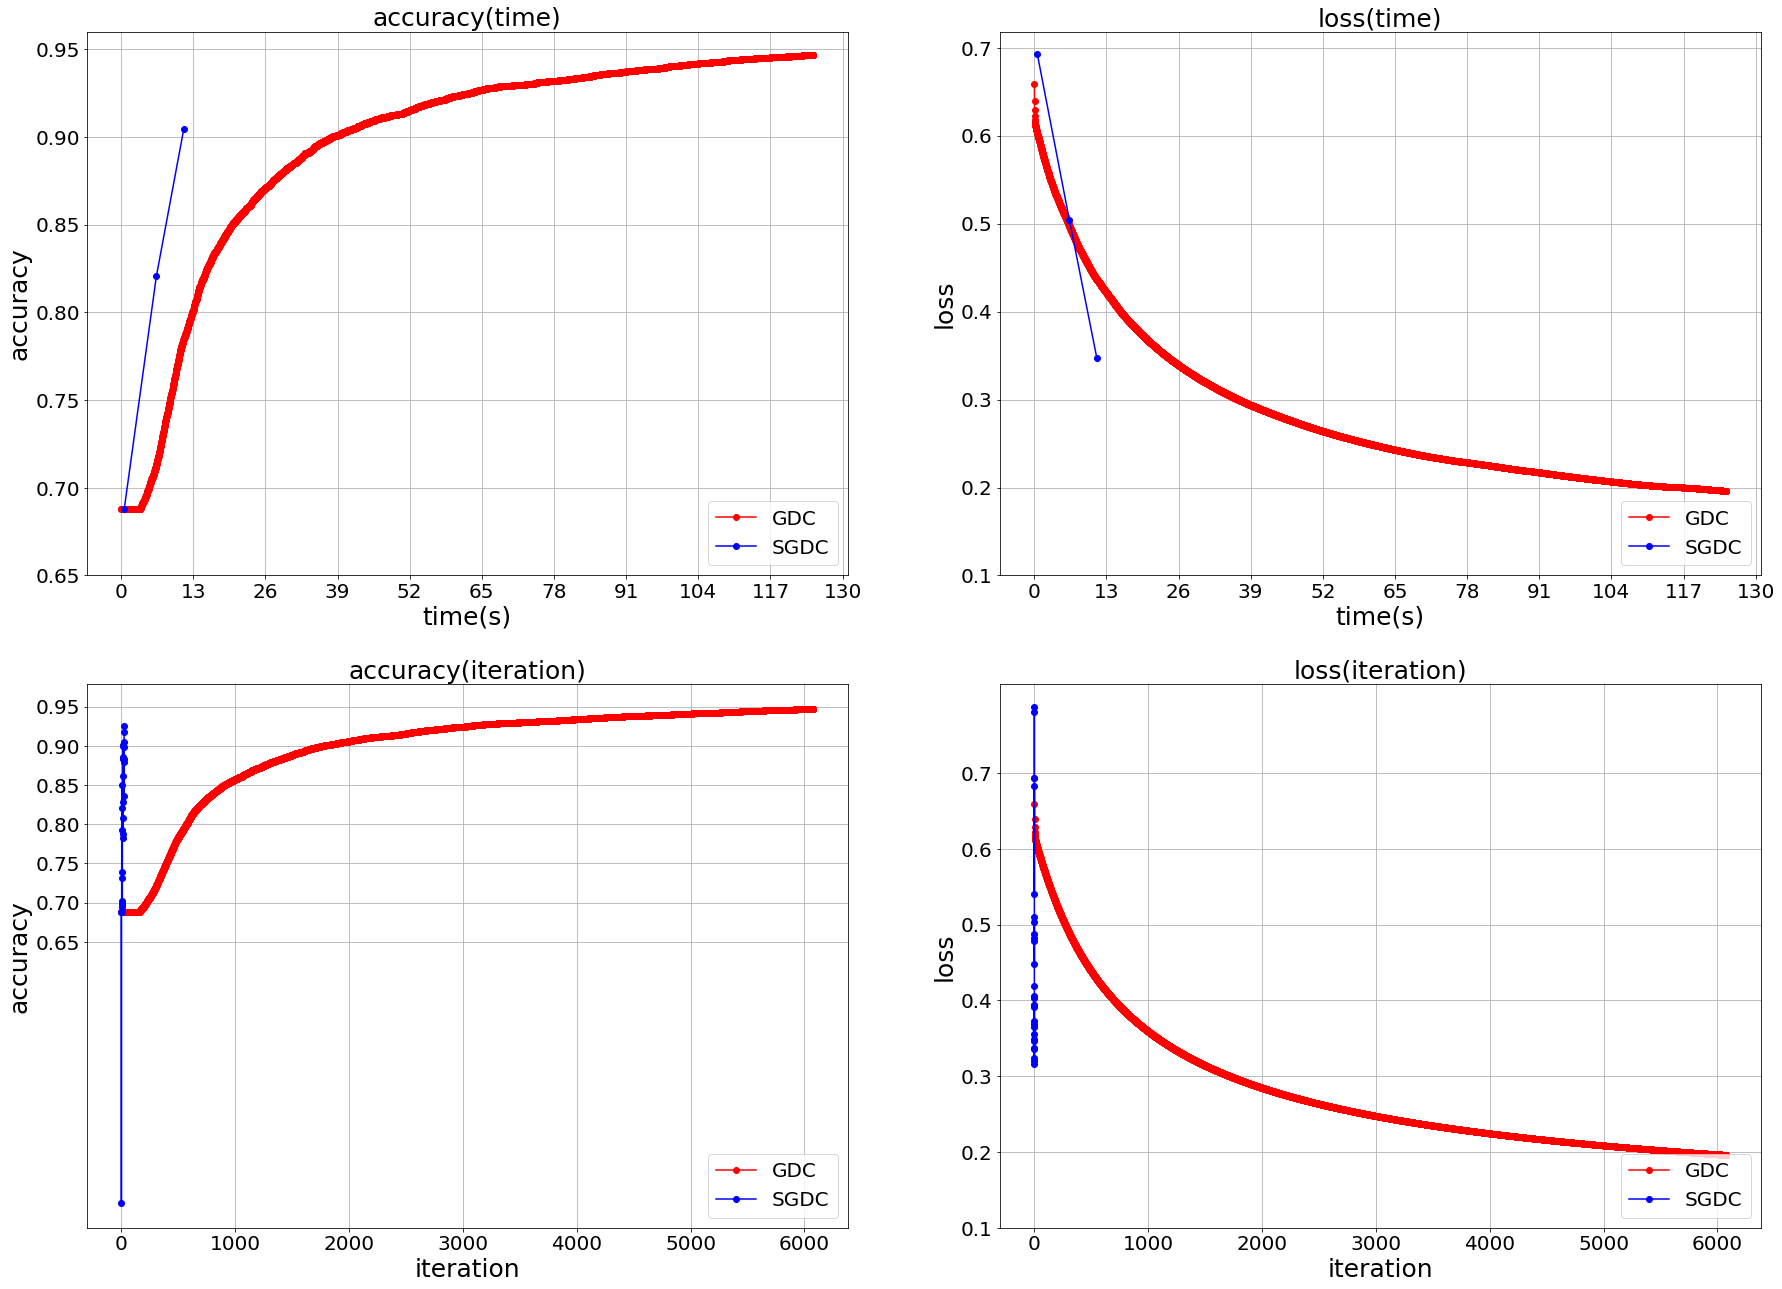

In [457]:
# создадим окружение
fig, ax = plt.subplots()

# зададим размеры рисунка
fig.set_figwidth(30)
fig.set_figheight(22)

# подпись ко всему
#plt.suptitle('GDC vs. SGDC', fontsize=30)

plt.subplot(2, 2, 1)
plt.grid(True)
plt.title('accuracy(time)', fontsize=25)

# добавим линии
plt.plot(gdc_history['cum_time'][0:], gdc_history['accuracy'][0:], 'ro-')
plt.plot(sgdc_history_0['cum_time'][0:][::10], sgdc_history_0['accuracy'][::10], 'bo-')

# установить разметку осей
plt.xticks(np.linspace(0, 130, 11), fontsize=20)
plt.yticks(np.linspace(0.65, 0.95, 7), fontsize=20)

# установить границы осей
#plt.xlim(0.5, 10.5)
#plt.ylim(0.960, 0.980)

# подпишем оси
plt.xlabel('time(s)', fontsize=25)
plt.ylabel('accuracy', fontsize=25)
plt.legend(['GDC', 'SGDC'], loc=4, fontsize=20)


plt.subplot(2, 2, 2)
plt.grid(True)
plt.title('loss(time)', fontsize=25)

# добавим линии
plt.plot(gdc_history['cum_time'][0:], gdc_history['func'][1:], 'ro-')
plt.plot(sgdc_history_0['cum_time'][0:][::10], sgdc_history_0['func'][:-1][::10], 'bo-')

# установить разметку осей
plt.xticks(np.linspace(0, 130, 11), fontsize=20)
plt.yticks(np.linspace(0.1, 0.7, 7), fontsize=20)

# установить границы осей
#plt.xlim(0.5, 10.5)
#plt.ylim(0.960, 0.980)

# подпишем оси
plt.xlabel('time(s)', fontsize=25)
plt.ylabel('loss', fontsize=25)
plt.legend(['GDC', 'SGDC'], loc=4, fontsize=20)

plt.subplot(2, 2, 3)
plt.grid(True)
plt.title('accuracy(iteration)', fontsize=25)

# добавим линии
plt.plot(range(len(gdc_history['accuracy'])), gdc_history['accuracy'], 'ro-')
plt.plot(range(0, len(sgdc_history_0['accuracy'])), sgdc_history_0['accuracy'], 'bo-')

# установить разметку осей
plt.xticks(np.linspace(0, 6000, 7), fontsize=20)
plt.yticks(np.linspace(0.65, 0.95, 7), fontsize=20)

# установить границы осей
#plt.xlim(0.5, 10.5)
#plt.ylim(0.960, 0.980)

# подпишем оси
plt.xlabel('iteration', fontsize=25)
plt.ylabel('accuracy', fontsize=25)
plt.legend(['GDC', 'SGDC'], loc=4, fontsize=20)

plt.subplot(2, 2, 4)
plt.grid(True)
plt.title('loss(iteration)', fontsize=25)

# добавим линии
plt.plot(range(len(gdc_history['func'])), gdc_history['func'], 'ro-')
plt.plot(sgdc_history_0['epoch_num'], sgdc_history_0['func'], 'bo-')

# установить разметку осей
plt.xticks(np.linspace(0, 6000, 7), fontsize=20)
plt.yticks(np.linspace(0.1, 0.7, 7), fontsize=20)


# установить границы осей
#plt.xlim(0.5, 10.5)
#plt.ylim(0.960, 0.980)

# подпишем оси
plt.xlabel('iteration', fontsize=25)
plt.ylabel('loss', fontsize=25)
plt.legend(['GDC', 'SGDC'], loc=4, fontsize=20)

# сохранить
plt.savefig('SGDC_GDC_1.pdf', bbox_inches='tight')

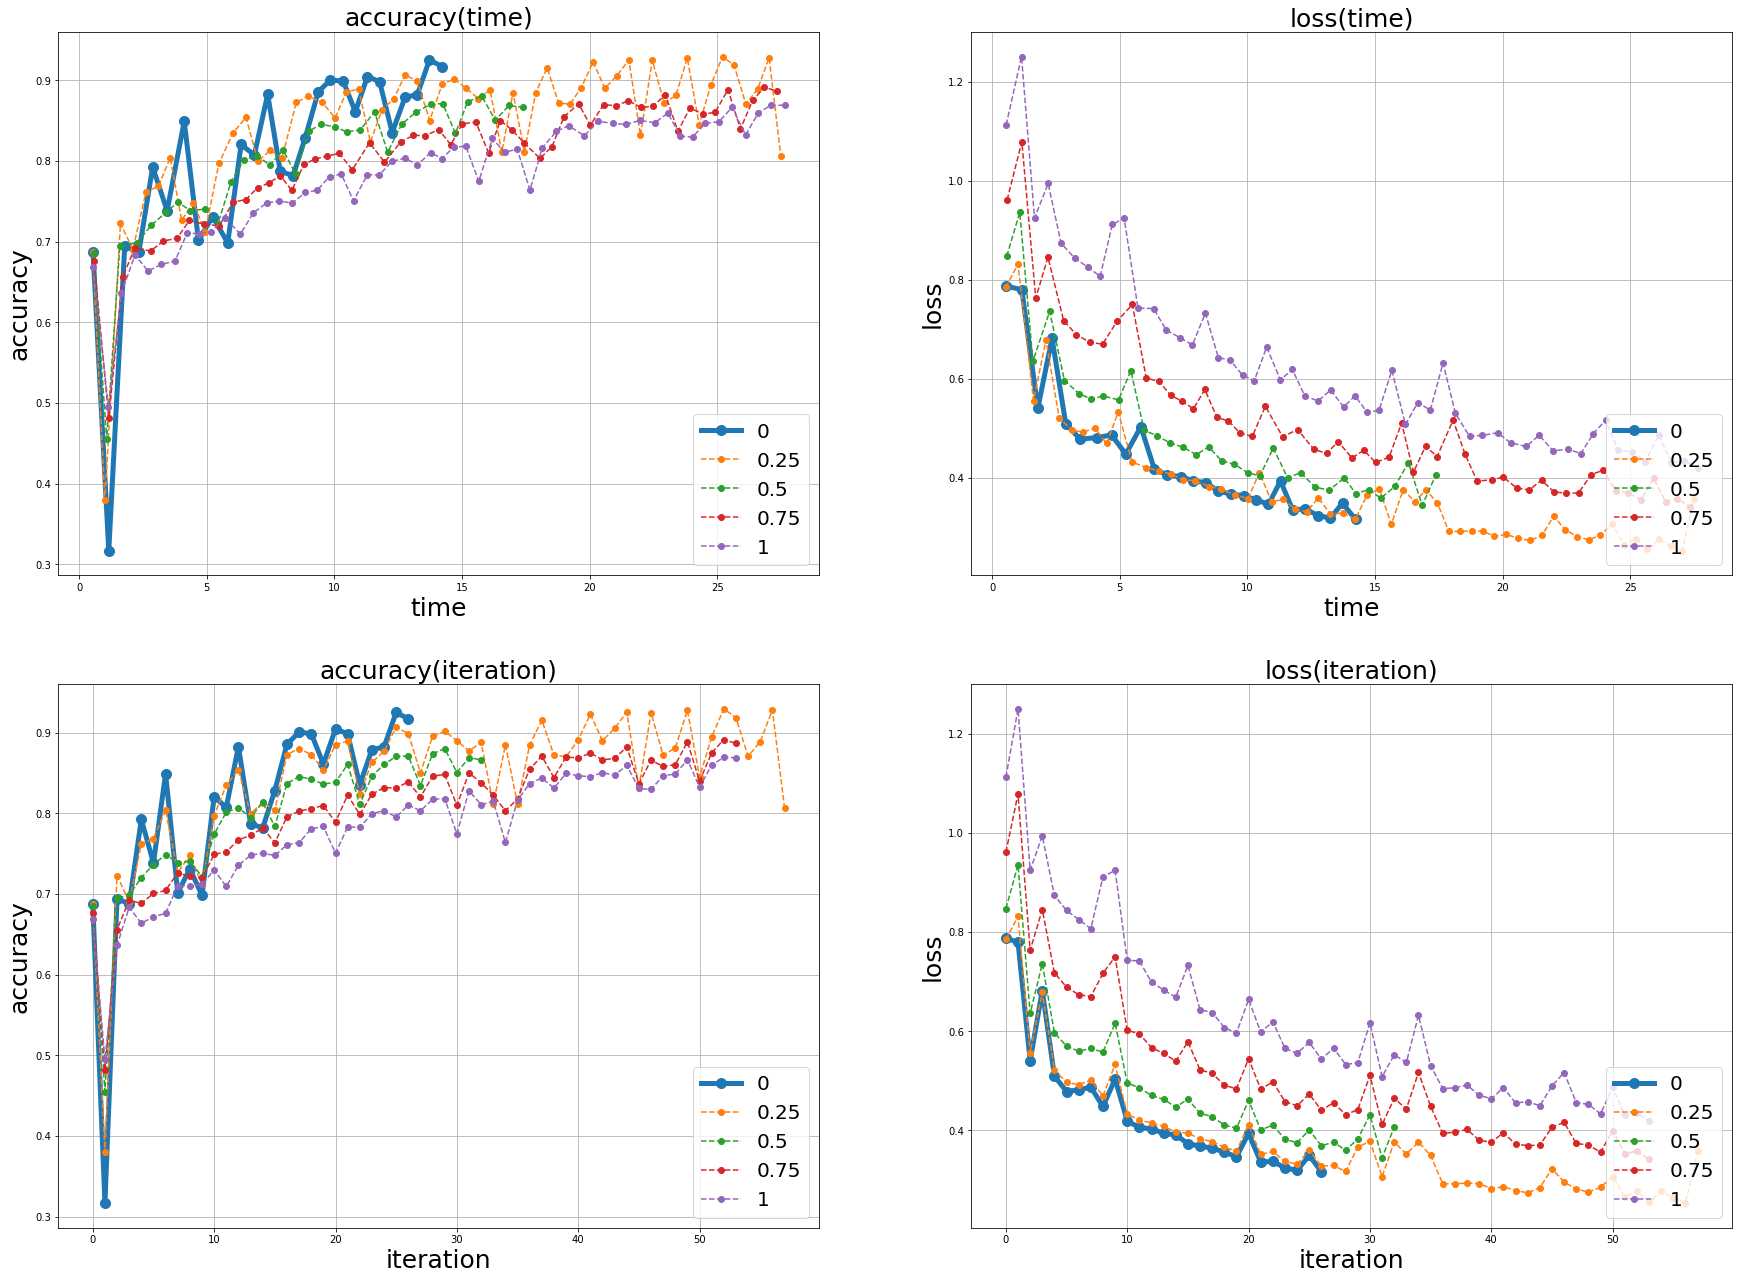

In [453]:
# создадим окружение
fig, ax = plt.subplots()

# зададим размеры рисунка
fig.set_figwidth(30)
fig.set_figheight(22)

# подпись ко всему
#plt.suptitle('GDC vs. SGDC', fontsize=30)

plt.subplot(2, 2, 2)
plt.grid(True)

plt.title('loss(time)', fontsize=25)

# добавим линии
plt.plot(sgdc_history_0['cum_time'], sgdc_history_0['func'][1:], 'o-', ms=10, linewidth=5)
plt.plot(sgdc_history_025['cum_time'], sgdc_history_025['func'][1:], 'o--')
plt.plot(sgdc_history_050['cum_time'], sgdc_history_050['func'][1:], 'o--')
plt.plot(sgdc_history_075['cum_time'], sgdc_history_075['func'][1:], 'o--')
plt.plot(sgdc_history_1['cum_time'], sgdc_history_1['func'][1:], 'o--')


# установить разметку осей
#plt.xticks(np.linspace(0, 6000, 7), fontsize=20)
#plt.yticks(np.linspace(0.65, 0.95, 7), fontsize=20)

# установить границы осей
#plt.xlim(0.5, 10.5)
#plt.ylim(0.960, 0.980)

# подпишем оси
plt.xlabel('time', fontsize=25)
plt.ylabel('loss', fontsize=25)
plt.legend(['0', '0.25', '0.5', '0.75', '1'], loc=4, fontsize=20)




plt.subplot(2, 2, 4)
plt.grid(True)

plt.title('loss(iteration)', fontsize=25)

# добавим линии

plt.plot(range(len(sgdc_history_0['func'][1:])), sgdc_history_0['func'][1:], 'o-', ms=10, linewidth=5)
plt.plot(range(len(sgdc_history_025['func'][1:])), sgdc_history_025['func'][1:], 'o--')
plt.plot(range(len(sgdc_history_050['func'][1:])), sgdc_history_050['func'][1:], 'o--')
plt.plot(range(len(sgdc_history_075['func'][1:])), sgdc_history_075['func'][1:], 'o--')
plt.plot(range(len(sgdc_history_1['func'][1:])), sgdc_history_1['func'][1:], 'o--')



# установить разметку осей
#plt.xticks(np.linspace(0, 6000, 7), fontsize=20)
#plt.yticks(np.linspace(0.1, 0.7, 7), fontsize=20)


# установить границы осей
#plt.xlim(0.5, 10.5)
#plt.ylim(0.960, 0.980)

# подпишем оси
plt.xlabel('iteration', fontsize=25)
plt.ylabel('loss', fontsize=25)
plt.legend(['0', '0.25', '0.5', '0.75', '1'], loc=4, fontsize=20)
plt.subplot(2, 2, 1)
plt.grid(True)
plt.title('accuracy(time)', fontsize=25)

# добавим линии
plt.plot(sgdc_history_0['cum_time'], sgdc_history_0['accuracy'], 'o-', ms=10, linewidth=5)
plt.plot(sgdc_history_025['cum_time'], sgdc_history_025['accuracy'], 'o--')
plt.plot(sgdc_history_050['cum_time'], sgdc_history_050['accuracy'], 'o--')
plt.plot(sgdc_history_075['cum_time'], sgdc_history_075['accuracy'], 'o--')
plt.plot(sgdc_history_1['cum_time'], sgdc_history_1['accuracy'], 'o--')


# установить разметку осей
#plt.xticks(np.linspace(0, 6000, 7), fontsize=20)
#plt.yticks(np.linspace(0.65, 0.95, 7), fontsize=20)

# установить границы осей
#plt.xlim(0.5, 10.5)
#plt.ylim(0.960, 0.980)

# подпишем оси
plt.xlabel('time', fontsize=25)
plt.ylabel('accuracy', fontsize=25)
plt.legend(['0', '0.25', '0.5', '0.75', '1'], loc=4, fontsize=20)

plt.subplot(2, 2, 3)
plt.grid(True)
plt.title('accuracy(iteration)', fontsize=25)

# добавим линии

plt.plot(range(len(sgdc_history_0['accuracy'])), sgdc_history_0['accuracy'], 'o-', ms=10, linewidth=5)
plt.plot(range(len(sgdc_history_025['accuracy'])), sgdc_history_025['accuracy'], 'o--')
plt.plot(range(len(sgdc_history_050['accuracy'])), sgdc_history_050['accuracy'], 'o--')
plt.plot(range(len(sgdc_history_075['accuracy'])), sgdc_history_075['accuracy'], 'o--')
plt.plot(range(len(sgdc_history_1['accuracy'])), sgdc_history_1['accuracy'], 'o--')



# установить разметку осей
#plt.xticks(np.linspace(0, 6000, 7), fontsize=20)
#plt.yticks(np.linspace(0.1, 0.7, 7), fontsize=20)


# установить границы осей
#plt.xlim(0.5, 10.5)
#plt.ylim(0.960, 0.980)

# подпишем оси
plt.xlabel('iteration', fontsize=25)
plt.ylabel('accuracy', fontsize=25)
plt.legend(['0', '0.25', '0.5', '0.75', '1'], loc=4, fontsize=20)



# сохранить
plt.savefig('SGDC_w_0_1.pdf', bbox_inches='tight')

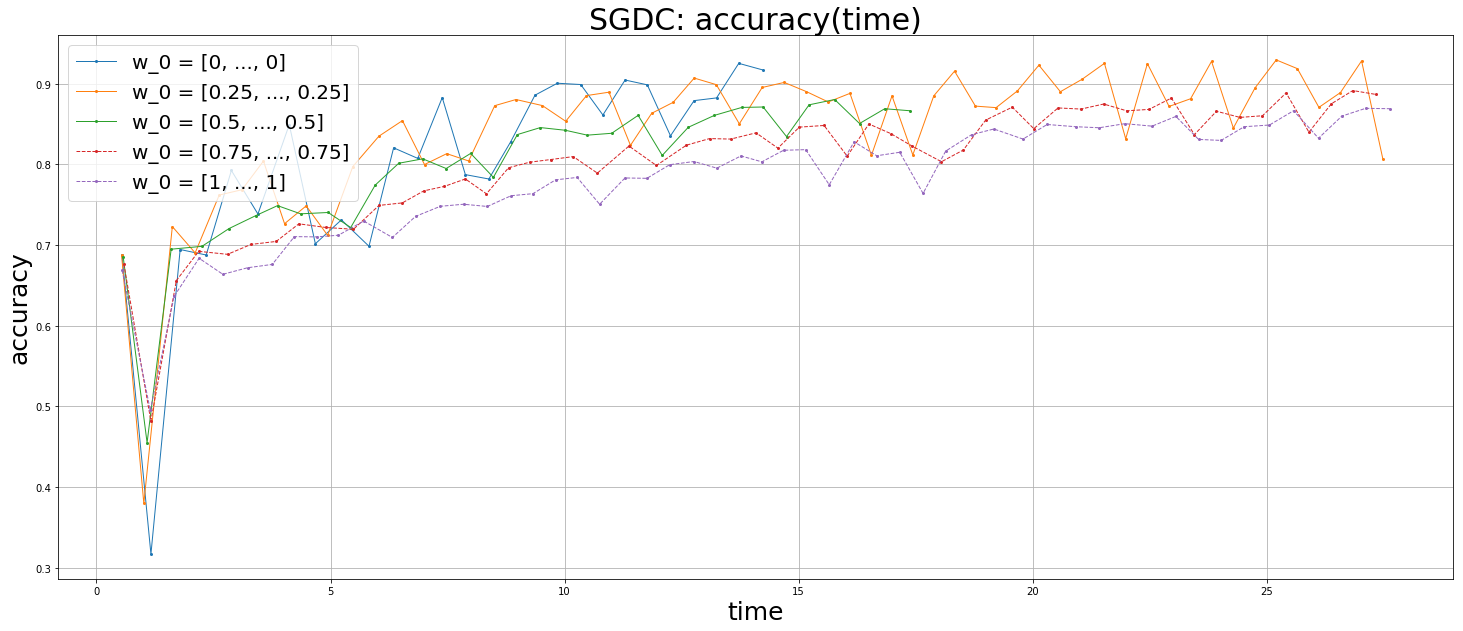

In [436]:

# создадим окружение
fig_2, ax = plt.subplots()

# зададим размеры рисунка
fig_2.set_figwidth(25)
fig_2.set_figheight(10)

ax.grid(True)
# заголовок рисунка
plt.title('SGDC: accuracy(time)', fontsize=30)

# добавим линии
plt.plot(sgdc_history_0['cum_time'], sgdc_history_0['accuracy'], 'o-', ms=2, linewidth=1)
plt.plot(sgdc_history_025['cum_time'], sgdc_history_025['accuracy'], 'o-', ms=2, linewidth=1)
plt.plot(sgdc_history_050['cum_time'], sgdc_history_050['accuracy'], 'o-', ms=2, linewidth=1)
plt.plot(sgdc_history_075['cum_time'], sgdc_history_075['accuracy'], 'o--', ms=2, linewidth=1)
plt.plot(sgdc_history_1['cum_time'], sgdc_history_1['accuracy'], 'o--', ms=2, linewidth=1)

# установить разметку осей
#plt.xticks(np.linspace(1, 10, 10), fontsize=20)
#plt.yticks(np.linspace(0.960, 0.980, 11), fontsize=20)

# установить границы осей
#plt.xlim(0.5, 10.5)
#plt.ylim(0.960, 0.980)

# подпишем оси
plt.xlabel('time', fontsize=25)
plt.ylabel('accuracy', fontsize=25)


# легенда
plt.legend(['w_0 = [0, ..., 0]', 'w_0 = [0.25, ..., 0.25]', 'w_0 = [0.5, ..., 0.5]', \
                'w_0 = [0.75, ..., 0.75]','w_0 = [1, ..., 1]'], loc=2, fontsize=20)

# сохранить
plt.savefig('SGDC_accuracy(time).pdf')

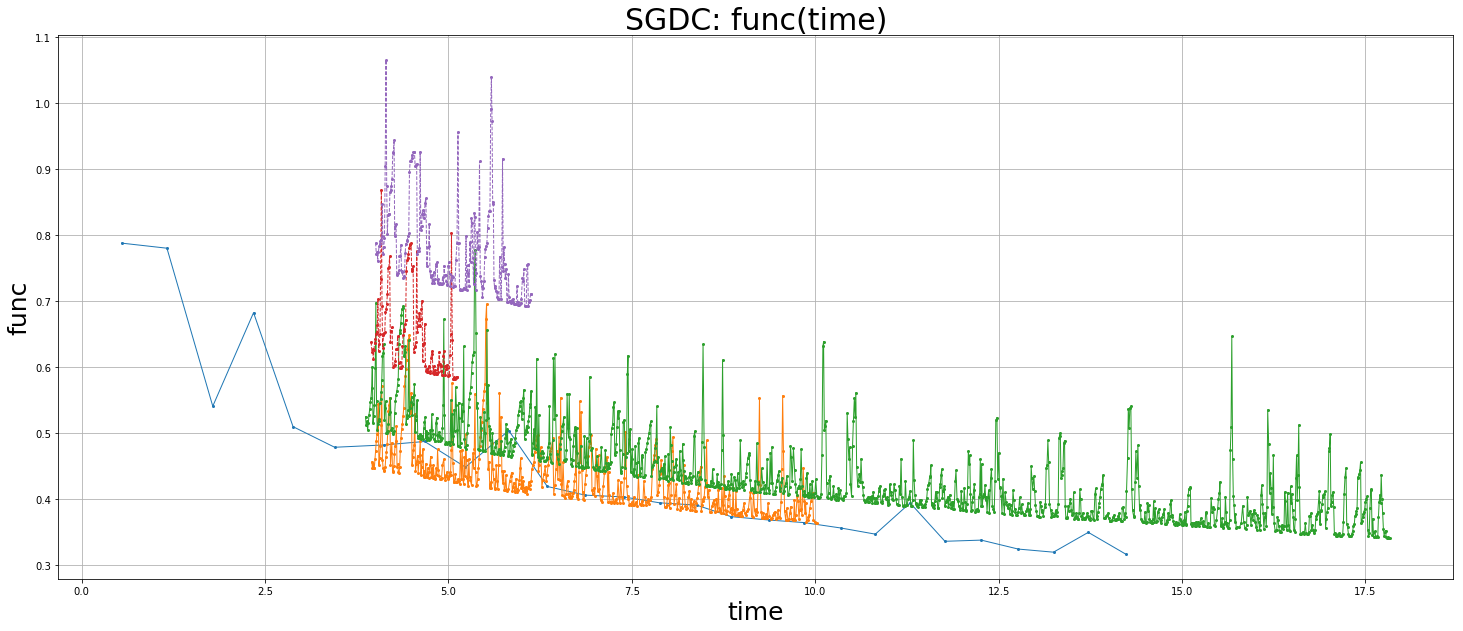

In [431]:
# создадим окружение
fig_2, ax = plt.subplots()

# зададим размеры рисунка
fig_2.set_figwidth(25)
fig_2.set_figheight(10)

ax.grid(True)
# заголовок рисунка
plt.title('SGDC: func(time)', fontsize=30)

# добавим линии
plt.plot(sgdc_history_0['cum_time'], sgdc_history_0['func'][1:], 'o-', ms=2, linewidth=1)
plt.plot(sgdc_history_025['cum_time'], sgdc_history_025['func'][1:], 'o-', ms=2, linewidth=1)
plt.plot(sgdc_history_050['cum_time'], sgdc_history_050['func'][1:], 'o-', ms=2, linewidth=1)
plt.plot(sgdc_history_075['cum_time'], sgdc_history_075['func'][1:], 'o--', ms=2, linewidth=1)
plt.plot(sgdc_history_1['cum_time'], sgdc_history_1['func'][1:], 'o--', ms=2, linewidth=1)

# установить разметку осей
#plt.xticks(np.linspace(1, 10, 10), fontsize=20)
#plt.yticks(np.linspace(0.960, 0.980, 11), fontsize=20)

# установить границы осей
#plt.xlim(0.5, 10.5)
#plt.ylim(0.960, 0.980)

# подпишем оси
plt.xlabel('time', fontsize=25)
plt.ylabel('func', fontsize=25)


# легенда
#plt.legend(['accuracy(time)'], loc=2, fontsize=20)

# сохранить
plt.savefig('SGDC_func(time).pdf')

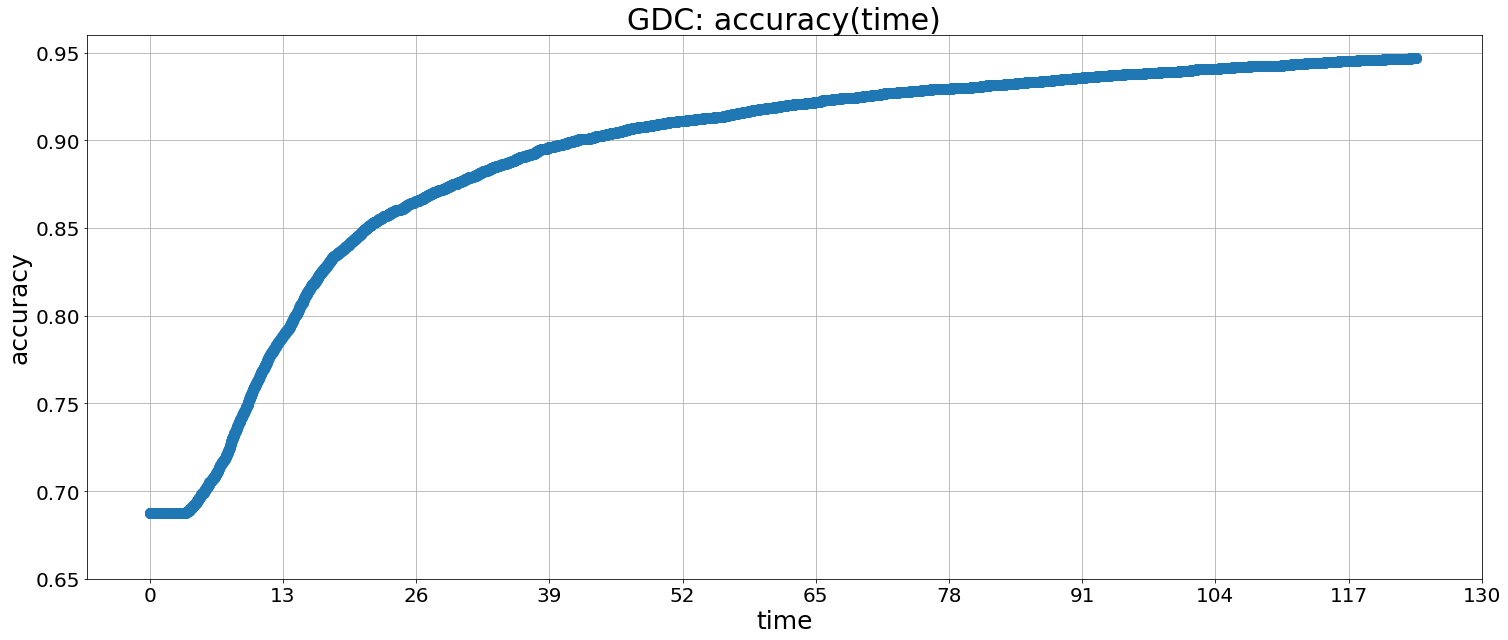

In [321]:
# создадим окружение
fig_2, ax = plt.subplots()

# зададим размеры рисунка
fig_2.set_figwidth(25)
fig_2.set_figheight(10)

ax.grid(True)
# заголовок рисунка
plt.title('GDC: accuracy(time)', fontsize=30)

# добавим линии
plt.plot(gdc_history['cum_time'][0:], gdc_history['accuracy'][0:], 'o-', ms=10, linewidth=5)


# установить разметку осей
plt.xticks(np.linspace(0, 130, 11), fontsize=20)
plt.yticks(np.linspace(0.65, 0.95, 7), fontsize=20)

# установить границы осей
#plt.xlim(0.5, 10.5)
#plt.ylim(0.960, 0.980)

# подпишем оси
plt.xlabel('time', fontsize=25)
plt.ylabel('accuracy', fontsize=25)


# легенда
#plt.legend(['accuracy(time)'], loc=2, fontsize=20)

# сохранить
plt.savefig('GDC_accuracy(time).pdf')

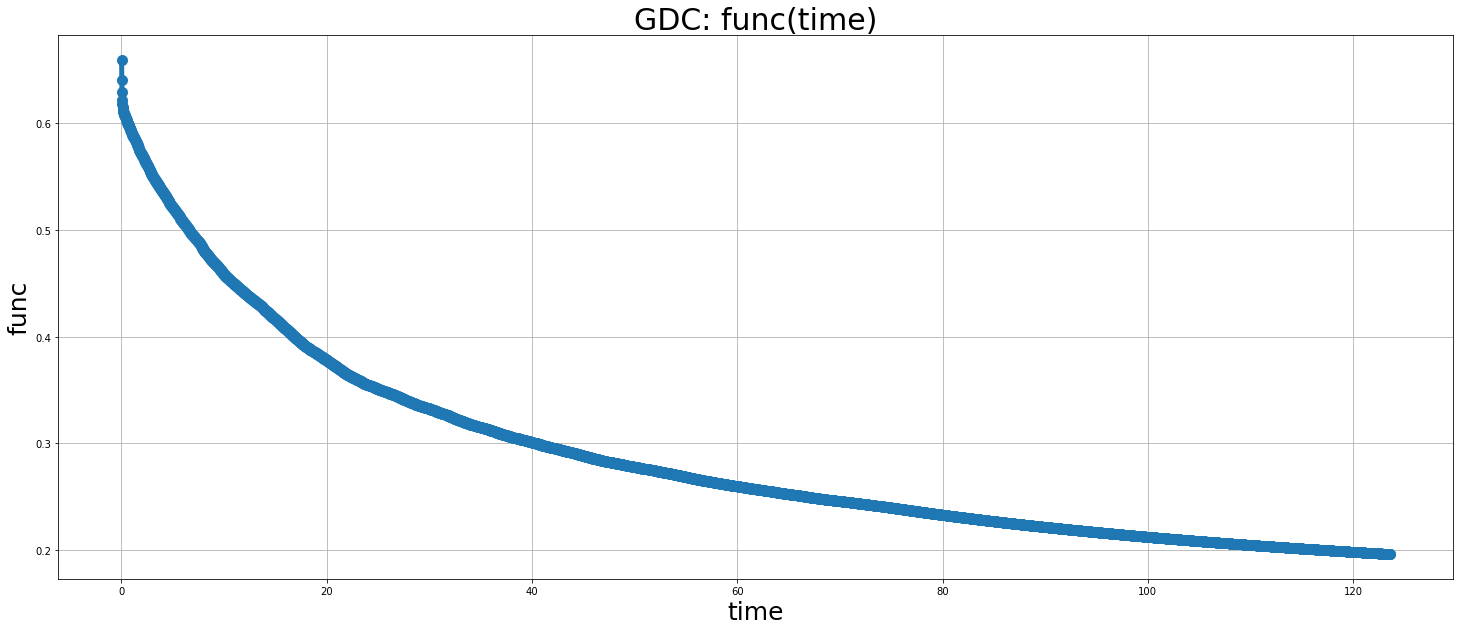

In [322]:
# создадим окружение
fig_2, ax = plt.subplots()

# зададим размеры рисунка
fig_2.set_figwidth(25)
fig_2.set_figheight(10)

ax.grid(True)
# заголовок рисунка
plt.title('GDC: func(time)', fontsize=30)

# добавим линии
plt.plot(gdc_history['cum_time'], gdc_history['func'][1:], 'o-', ms=10, linewidth=5)


# установить разметку осей
#plt.xticks(np.linspace(1, 10, 10), fontsize=20)
#plt.yticks(np.linspace(0.960, 0.980, 11), fontsize=20)

# установить границы осей
#plt.xlim(0.5, 10.5)
#plt.ylim(0.960, 0.980)

# подпишем оси
plt.xlabel('time', fontsize=25)
plt.ylabel('func', fontsize=25)


# легенда
#plt.legend(['accuracy(time)'], loc=2, fontsize=20)

# сохранить
plt.savefig('GDC_func(time).pdf')

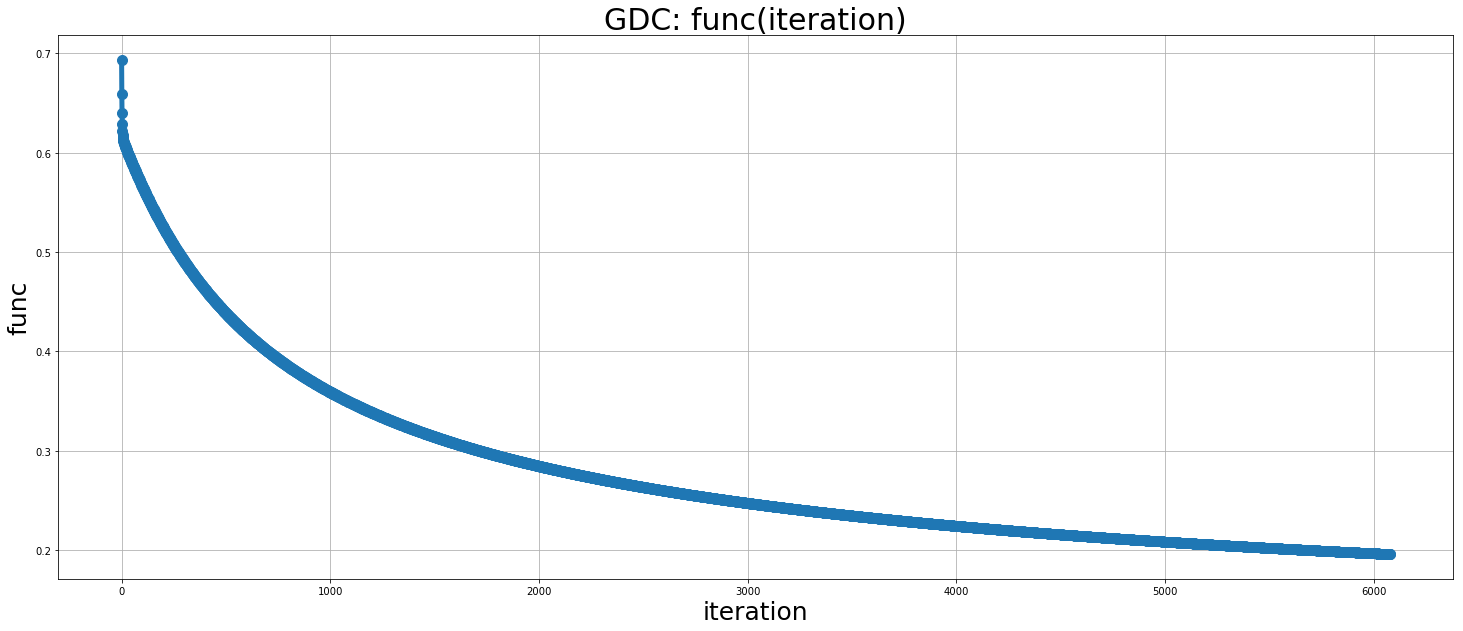

In [323]:
# создадим окружение
fig_2, ax = plt.subplots()

# зададим размеры рисунка
fig_2.set_figwidth(25)
fig_2.set_figheight(10)

ax.grid(True)
# заголовок рисунка
plt.title('GDC: func(iteration)', fontsize=30)

# добавим линии
plt.plot(range(len(gdc_history['func'])), gdc_history['func'], 'o-', ms=10, linewidth=5)


# установить разметку осей
#plt.xticks(np.linspace(1, 10, 10), fontsize=20)
#plt.yticks(np.linspace(0.960, 0.980, 11), fontsize=20)

# установить границы осей
#plt.xlim(0.5, 10.5)
#plt.ylim(0.960, 0.980)

# подпишем оси
plt.xlabel('iteration', fontsize=25)
plt.ylabel('func', fontsize=25)


# легенда
#plt.legend(['accuracy(time)'], loc=2, fontsize=20)

# сохранить
plt.savefig('GDC_func(iteration)).pdf')

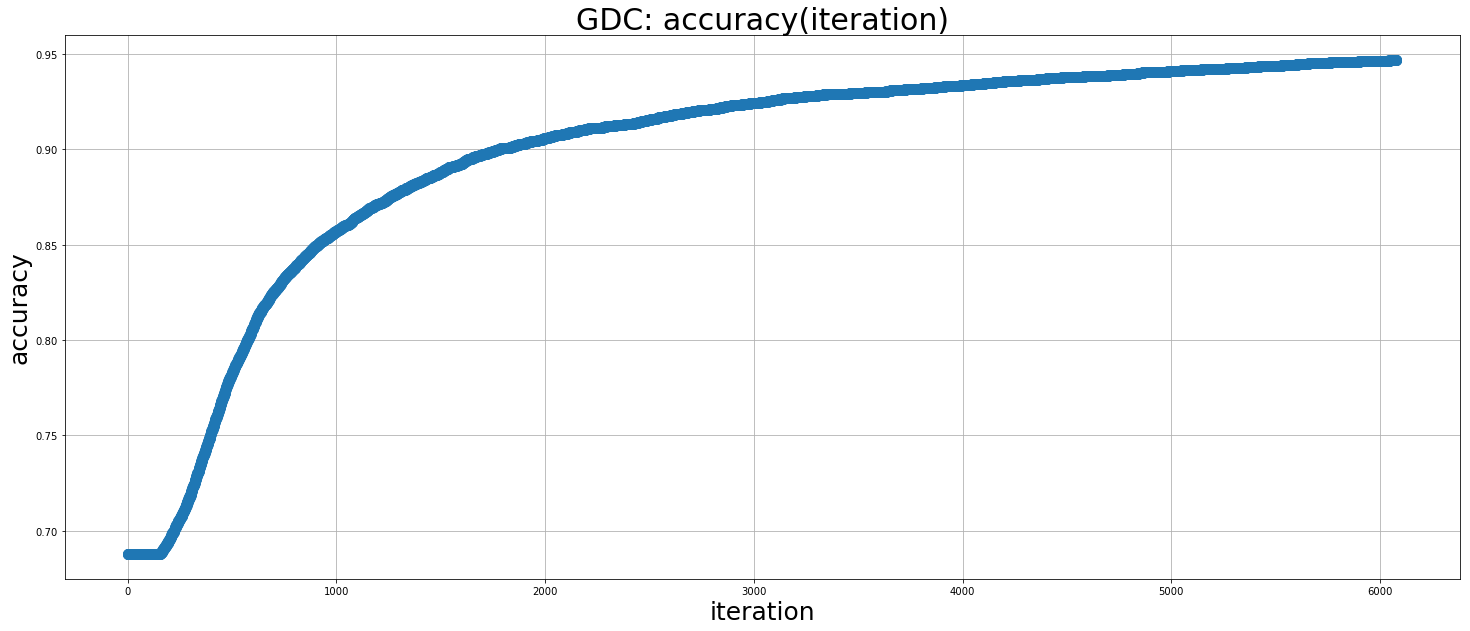

In [324]:
# создадим окружение
fig_2, ax = plt.subplots()

# зададим размеры рисунка
fig_2.set_figwidth(25)
fig_2.set_figheight(10)

ax.grid(True)
# заголовок рисунка
plt.title('GDC: accuracy(iteration)', fontsize=30)

# добавим линии
plt.plot(range(1, len(gdc_history['accuracy'][0:]) + 1), gdc_history['accuracy'][0:], 'o-', ms=10, linewidth=5)

# установить разметку осей
#plt.xticks(np.linspace(1, 10, 10), fontsize=20)
#plt.yticks(np.linspace(0.960, 0.980, 11), fontsize=20)

# установить границы осей
#plt.xlim(0.5, 10.5)
#plt.ylim(0.960, 0.980)

# подпишем оси
plt.xlabel('iteration', fontsize=25)
plt.ylabel('accuracy', fontsize=25)


# легенда
#plt.legend(['accuracy(time)'], loc=2, fontsize=20)

# сохранить
plt.savefig('GDC_accuracy(iteration).pdf')

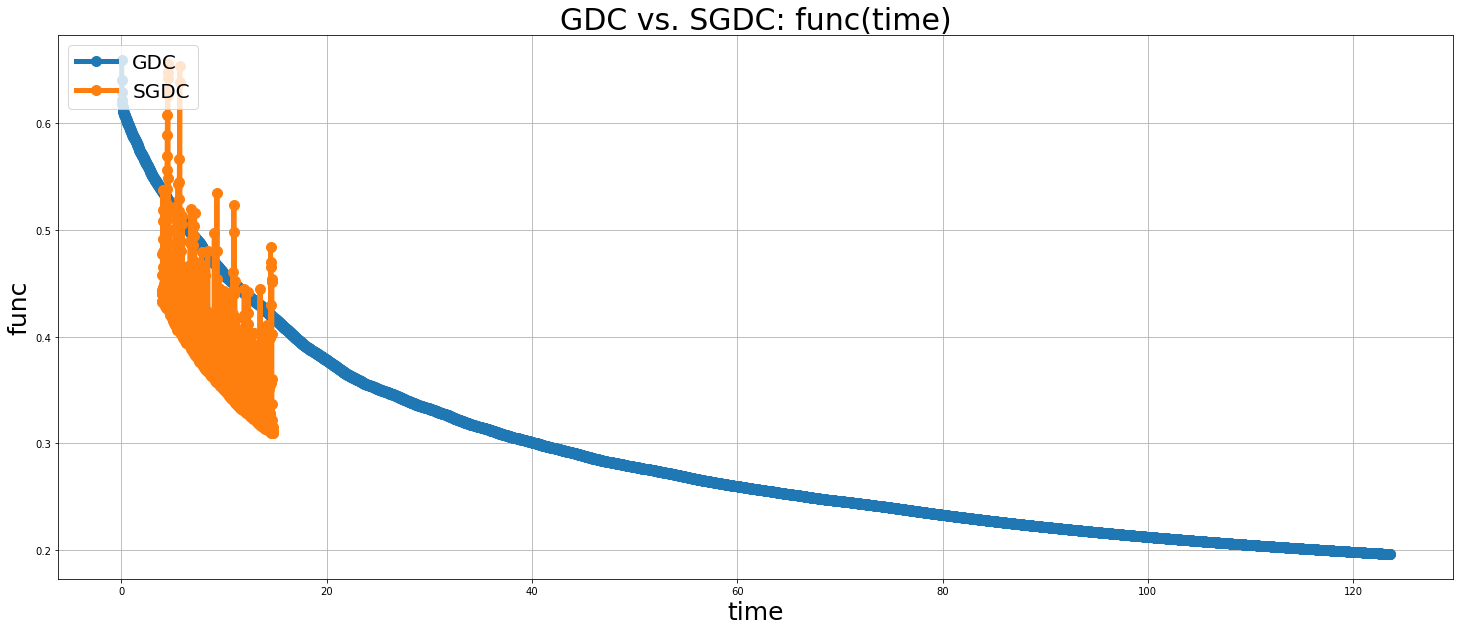

In [325]:
# создадим окружение
fig_2, ax = plt.subplots()

# зададим размеры рисунка
fig_2.set_figwidth(25)
fig_2.set_figheight(10)

ax.grid(True)
# заголовок рисунка
plt.title('GDC vs. SGDC: func(time)', fontsize=30)

# добавим линии
plt.plot(gdc_history['cum_time'], gdc_history['func'][1:], 'o-', ms=10, linewidth=5)
plt.plot(sgdc_history_0['cum_time'], sgdc_history_0['func'][1:], 'o-', ms=10, linewidth=5)


# установить разметку осей
#plt.xticks(np.linspace(1, 10, 10), fontsize=20)
#plt.yticks(np.linspace(0.960, 0.980, 11), fontsize=20)

# установить границы осей
#plt.xlim(0.5, 10.5)
#plt.ylim(0.960, 0.980)

# подпишем оси
plt.xlabel('time', fontsize=25)
plt.ylabel('func', fontsize=25)


# легенда
plt.legend(['GDC','SGDC'], loc=2, fontsize=20)

# сохранить
plt.savefig('GDC vs. SGDC_func(time).pdf')

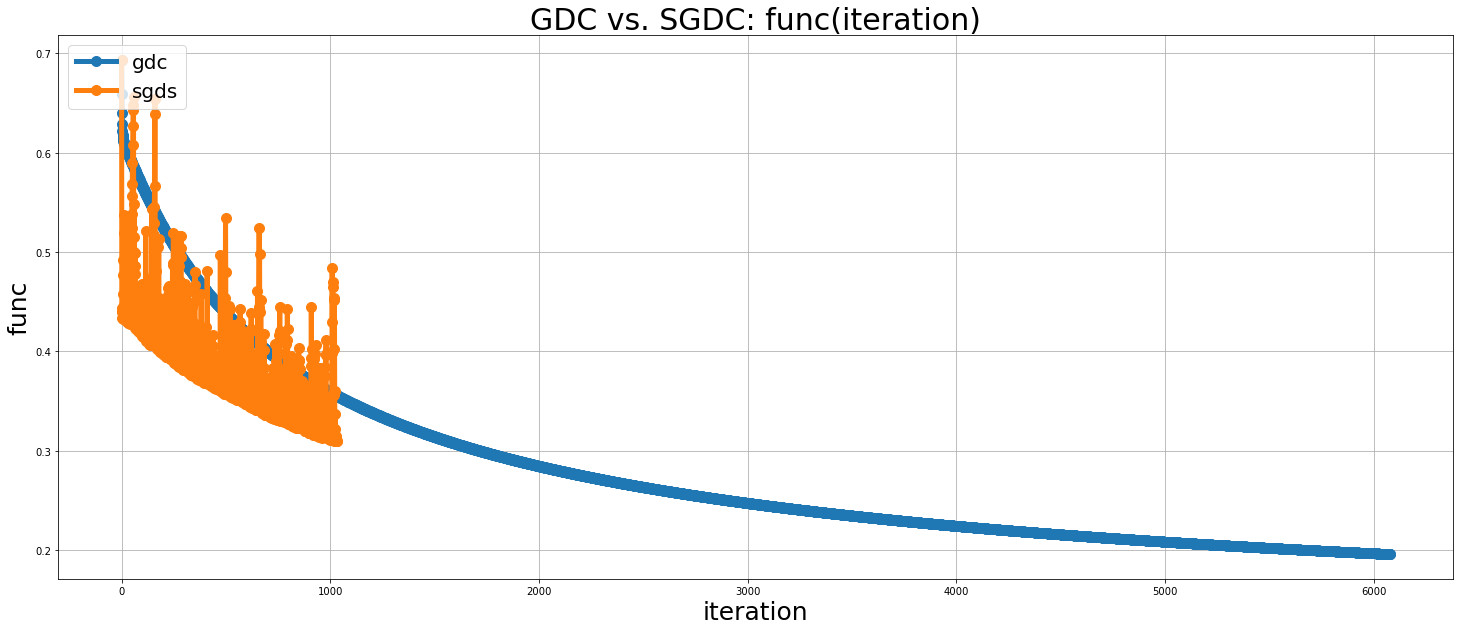

In [326]:
# создадим окружение
fig_2, ax = plt.subplots()

# зададим размеры рисунка
fig_2.set_figwidth(25)
fig_2.set_figheight(10)

ax.grid(True)
# заголовок рисунка
plt.title('GDC vs. SGDC: func(iteration)', fontsize=30)

# добавим линии
plt.plot(range(len(gdc_history['func'])), gdc_history['func'], 'o-', ms=10, linewidth=5)
plt.plot(range(len(sgdc_history_0['func'])), sgdc_history_0['func'], 'o-', ms=10, linewidth=5)



# установить разметку осей
#plt.xticks(np.linspace(1, 10, 10), fontsize=20)
#plt.yticks(np.linspace(0.960, 0.980, 11), fontsize=20)

# установить границы осей
#plt.xlim(0.5, 10.5)
#plt.ylim(0.960, 0.980)

# подпишем оси
plt.xlabel('iteration', fontsize=25)
plt.ylabel('func', fontsize=25)


# легенда
plt.legend(['gdc', 'sgds'], loc=2, fontsize=20)

# сохранить
plt.savefig('GDC_func(iteration)).pdf')

2 

Исследуйте как влияют параметры размера шага step_alpha и step_beta на качество работы обоих методов (здесь и далее под качеством подрузамеваются значение оптимизируемой функции и точность решения). Проверьте значения step_alpha {0.1, 1, 100, 1000} при зафиксированном step_beta = 0. Остальные параметры оставьте такими же, как и в предыдущем эксперименте. Попробуйте использовать другие значения step_beta. Проанализируйте, даёт ли это прирост в качестве и причины этого.

In [728]:
gdc_classifier_alpha_01 = GDClassifier(loss_function='binary_logistic', step_alpha=0.1, max_iter=10000)
gdc_classifier_alpha_1 = GDClassifier(loss_function='binary_logistic', step_alpha=1, max_iter=10000)
gdc_classifier_alpha_100 = GDClassifier(loss_function='binary_logistic', step_alpha=100, max_iter=10000)
gdc_classifier_alpha_1000 = GDClassifier(loss_function='binary_logistic', step_alpha=1000, max_iter=10000)

In [729]:
tp.send_text('full alpha start')
gdc_classifier_alpha_01.fit(X=X_train, y=y_train)
tp.send_text('full alpha 0.1 end')
gdc_classifier_alpha_1.fit(X=X_train, y=y_train)
tp.send_text('full alpha 1 end')
gdc_classifier_alpha_100.fit(X=X_train, y=y_train)
tp.send_text('full alpha 100 end')
gdc_classifier_alpha_1000.fit(X=X_train, y=y_train)
tp.send_text('full alpha 1000 end')

200

In [730]:
y_pred_full_alpha_01 = gdc_classifier_alpha_01.predict(X=X_test)
y_pred_full_alpha_1 = gdc_classifier_alpha_1.predict(X=X_test)
y_pred_full_alpha_100 = gdc_classifier_alpha_100.predict(X=X_test)
y_pred_full_alpha_1000 = gdc_classifier_alpha_1000.predict(X=X_test)

In [731]:
func_full_alpha_01 = gdc_classifier_alpha_01.get_objective(X_train, y_train)
func_full_alpha_1 = gdc_classifier_alpha_1.get_objective(X_train, y_train)
func_full_alpha_100 = gdc_classifier_alpha_100.get_objective(X_train, y_train)
func_full_alpha_1000 = gdc_classifier_alpha_1000.get_objective(X_train, y_train)

In [732]:
print(func_full_alpha_01)
print(func_full_alpha_1)
print(func_full_alpha_100)
print(func_full_alpha_1000)

0.359138258164
0.196180976138
0.238626761968
47.9380796452


In [733]:
accuracy_full_alpha_01 = accuracy_score(y_true=y_test, y_pred=y_pred_full_alpha_01)
accuracy_full_alpha_1 = accuracy_score(y_true=y_test, y_pred=y_pred_full_alpha_1)
accuracy_full_alpha_100 = accuracy_score(y_true=y_test, y_pred=y_pred_full_alpha_100)
accuracy_full_alpha_1000 = accuracy_score(y_true=y_test, y_pred=y_pred_full_alpha_1000)

In [734]:
print(accuracy_full_alpha_01)
print(accuracy_full_alpha_1)
print(accuracy_full_alpha_100)
print(accuracy_full_alpha_1000)

0.857063834495
0.946952096471
0.962938378139
0.703838920235


In [735]:
sgdc_classifier_alpha_01 = SGDClassifier(loss_function='binary_logistic', step_alpha=0.1, max_iter=10000)
sgdc_classifier_alpha_1 = SGDClassifier(loss_function='binary_logistic', step_alpha=1, max_iter=10000)
sgdc_classifier_alpha_100 = SGDClassifier(loss_function='binary_logistic', step_alpha=100, max_iter=10000)
sgdc_classifier_alpha_1000 = SGDClassifier(loss_function='binary_logistic', step_alpha=1000, max_iter=10000)

In [736]:
tp.send_text('stochastic alpha start')
sgdc_history_alpha_01 = sgdc_classifier_alpha_01.fit(X=X_train, y=y_train)
tp.send_text('stochastic alpha 0.1 end')
sgdc_history_alpha_1 = sgdc_classifier_alpha_1.fit(X=X_train, y=y_train)
tp.send_text('stochastic alpha 1 end')
sgdc_history_alpha_100 = sgdc_classifier_alpha_100.fit(X=X_train, y=y_train)
tp.send_text('stochastic alpha 100 end')
sgdc_history_alpha_1000 = sgdc_classifier_alpha_1000.fit(X=X_train, y=y_train)
tp.send_text('stochastic alpha end')

200

In [737]:
y_pred_stochastic_alpha_01 = sgdc_classifier_alpha_01.predict(X=X_test)
y_pred_stochastic_alpha_1 = sgdc_classifier_alpha_1.predict(X=X_test)
y_pred_stochastic_alpha_100 = sgdc_classifier_alpha_100.predict(X=X_test)
y_pred_stochastic_alpha_1000 = sgdc_classifier_alpha_1000.predict(X=X_test)

In [738]:
func_stochastic_alpha_01 = sgdc_classifier_alpha_01.get_objective(X_train, y_train)
func_stochastic_alpha_1 = sgdc_classifier_alpha_1.get_objective(X_train, y_train)
func_stochastic_alpha_100 = sgdc_classifier_alpha_100.get_objective(X_train, y_train)
func_stochastic_alpha_1000 = sgdc_classifier_alpha_1000.get_objective(X_train, y_train)

In [739]:
print(func_stochastic_alpha_01)
print(func_stochastic_alpha_1)
print(func_stochastic_alpha_100)
print(func_stochastic_alpha_1000)

0.366058174263
0.188212276963
14.428566465
124.642167828


In [740]:
accuracy_stochastic_alpha_01 = accuracy_score(y_true=y_test, y_pred=y_pred_stochastic_alpha_01)
accuracy_stochastic_alpha_1 = accuracy_score(y_true=y_test, y_pred=y_pred_stochastic_alpha_1)
accuracy_stochastic_alpha_100 = accuracy_score(y_true=y_test, y_pred=y_pred_stochastic_alpha_100)
accuracy_stochastic_alpha_1000 = accuracy_score(y_true=y_test, y_pred=y_pred_stochastic_alpha_1000)

In [741]:
print(accuracy_stochastic_alpha_01)
print(accuracy_stochastic_alpha_1)
print(accuracy_stochastic_alpha_100)
print(accuracy_stochastic_alpha_1000)

0.816849208983
0.92936165505
0.754176346941
0.709093926319


In [22]:

for step_beta in {0, 0.1, 0.01, 0.5, 1, 2}:
    for step_alpha in {0.1, 1, 100, 1000}:
        gdc_classifier_alpha_01 = GDClassifier(loss_function='binary_logistic', \
                                            step_alpha=step_alpha, \
                                            step_beta=step_beta, \
                                            max_iter=10000)
        tp.send_text('full start')
        gdc_classifier_alpha_01.fit(X=X_train, y=y_train)
        tp.send_text('full end')
        y_pred_full_alpha_01 = gdc_classifier_alpha_01.predict(X=X_test)
        func_full_alpha_01 = gdc_classifier_alpha_01.get_objective(X_train, y_train)
        accuracy_full_alpha_01 = accuracy_score(y_true=y_test, y_pred=y_pred_full_alpha_01)
        sgdc_classifier_alpha_01 = SGDClassifier(loss_function='binary_logistic', \
                                                 step_alpha=step_alpha, \
                                                 step_beta=step_beta, \
                                                 max_iter=10000)
        
        tp.send_text('stochastic alpha start')
        sgdc_history_alpha_01 = sgdc_classifier_alpha_01.fit(X=X_train, y=y_train)
        tp.send_text('stochastic alpha end')
        y_pred_stochastic_alpha_01 = sgdc_classifier_alpha_01.predict(X=X_test)
        func_stochastic_alpha_01 = sgdc_classifier_alpha_01.get_objective(X_train, y_train)
        accuracy_stochastic_alpha_01 = accuracy_score(y_true=y_test, y_pred=y_pred_stochastic_alpha_01)
        print(step_alpha, step_beta, func_full_alpha_01, accuracy_full_alpha_01, func_stochastic_alpha_01, accuracy_stochastic_alpha_01)

0.1 0 0.359138258164 0.857063834495 0.607813089833 0.687631375152
1 0 0.196180976138 0.946952096471 0.562938360587 0.69183538002
100 0 0.238626761968 0.962938378139 14.428566465 0.754176346941
1000 0 47.9380796452 0.703838920235 124.642167828 0.709093926319
0.1 0.5 0.617630148706 0.687631375152 0.610461901894 0.687631375152
1 0.5 0.569900333594 0.687631375152 0.608743125268 0.687631375152
100 0.5 0.171779089907 0.956023896449 2.13409024828 0.701349706826
1000 0.5 0.137138341124 0.971346387875 1.81534554143 0.934561345282
0.1 0.1 0.456586875143 0.758933510344 0.600175837055 0.687631375152
1 0.1 0.238700125404 0.928808496515 0.423817224708 0.78587233101
100 0.1 0.133351565624 0.970129439097 2.80793812346 0.902312202677
1000 0.1 15.05927221 0.715897776303 59.487409151 0.745270494524
0.1 1 0.672312738812 0.687631375152 0.680920691624 0.687631375152
1 1 0.616255715741 0.687631375152 0.621816033089 0.687631375152
100 1 0.382654329931 0.839473393074 0.523547888755 0.760537670096
1000 1 0.1782

3

Исследуйте как влияет случайность выбора объектов (random_seed) в алгоритме стохастического гради- ентного спуска на качество метода при одном и том же начальном приближении.

In [742]:
sgdc_accuracy_with_seed = []
sgdc_function_with_seed = []
tp.send_text('start')
for seed in {2, 10, 50, 150, 1000}:
    sgdc_classifier_with_seed = SGDClassifier(loss_function='binary_logistic', \
                                                    random_seed=seed, \
                                                    max_iter=10000)
    tp.send_text('sgdc_with_seed start')
    sgdc_classifier_with_seed.fit(X=X_train, y=y_train)
    tp.send_text('sgdc_with_seed end')
    y_pred_tmp = sgdc_classifier_with_seed.predict(X=X_test)
    sgdc_accuracy_with_seed.append(accuracy_score(y_true=y_test, y_pred=y_pred_tmp))
    sgdc_function_with_seed.append(sgdc_classifier_with_seed.get_objective(X_train, y_train))
tp.send_text('finished')

200

In [743]:
print(sgdc_accuracy_with_seed)
print(sgdc_function_with_seed)

[0.92371943799092815, 0.94728399159199028, 0.94877751963712798, 0.94955194158645873, 0.95419847328244278]
[0.19102670648793765, 0.17498010506456491, 0.19318531668142494, 0.17468764342721296, 0.17296802165225184]


4

Исследуйте как влияет размер подвыборки batch_size на качество метода стохастического градиентно- го спуска. Рассмотрите размеры {1, 5, 10, 20, 50, 100}. Дополнительно исследуйте как изменились зависимости метода от других параметров алгоритма при размерах подвыборки отличных от 1.

In [744]:
sgdc_accuracy_with_batch_size = []
sgdc_function_with_batch_size = []
tp.send_text('start')
for batch_size in {1, 5, 10, 20, 50, 100}:
    sgdc_classifier_with_batch_size = SGDClassifier(loss_function='binary_logistic', \
                                                    batch_size=batch_size, \
                                                    max_iter=10000)
    tp.send_text('sgdc_with_batch_size start')
    sgdc_classifier_with_batch_size.fit(X=X_train, y=y_train)
    tp.send_text('sgdc_with_batch_size end')
    y_pred_tmp = sgdc_classifier_with_batch_size.predict(X=X_test)
    sgdc_accuracy_with_batch_size.append(accuracy_score(y_true=y_test, y_pred=y_pred_tmp))
    sgdc_function_with_batch_size.append(sgdc_classifier_with_batch_size.get_objective(X_train, y_train))
tp.send_text('finished')

200

In [745]:
print(sgdc_accuracy_with_batch_size)
print(sgdc_function_with_batch_size)

[0.92936165505033741, 0.95475163181767897, 0.92294501604159751, 0.93301250138289638, 0.95281557694435226, 0.94545856842571085]
[0.18821227696279208, 0.17009446148040214, 0.18801429140482112, 0.18119077918474358, 0.17039876752645328, 0.17346922508942977]


In [23]:

for step_beta in {0, 0.1, 0.01, 0.5, 1, 2}:
    for step_alpha in {0.1, 1, 100, 1000}:
        sgdc_classifier_10 = SGDClassifier(loss_function='binary_logistic', \
                                            step_alpha=step_alpha, \
                                            step_beta=step_beta, \
                                               batch_size=10,
                                            max_iter=10000)
        tp.send_text('full start')
        sgdc_classifier_10.fit(X=X_train, y=y_train)
        tp.send_text('full end')
        y_pred_full_alpha_01 = sgdc_classifier_10.predict(X=X_test)
        func_full_alpha_01 = sgdc_classifier_10.get_objective(X_train, y_train)
        accuracy_full_alpha_01 = accuracy_score(y_true=y_test, y_pred=y_pred_full_alpha_01)
        
        sgdc_classifier_100 = SGDClassifier(loss_function='binary_logistic', \
                                                 step_alpha=step_alpha, \
                                                 step_beta=step_beta, \
                                                batch_size=100, \
                                                 max_iter=10000)
        
        tp.send_text('stochastic alpha start')
        sgdc_history_alpha_01 = sgdc_classifier_100.fit(X=X_train, y=y_train)
        tp.send_text('stochastic alpha end')
        y_pred_stochastic_alpha_01 = sgdc_classifier_100.predict(X=X_test)
        func_stochastic_alpha_01 = sgdc_classifier_100.get_objective(X_train, y_train)
        accuracy_stochastic_alpha_01 = accuracy_score(y_true=y_test, y_pred=y_pred_stochastic_alpha_01)
        print(step_alpha, step_beta, func_full_alpha_01, accuracy_full_alpha_01, func_stochastic_alpha_01, accuracy_stochastic_alpha_01)

0.1 0 0.602637696815 0.687631375152 0.610447695073 0.687631375152
1 0 0.480044758953 0.754342294502 0.559366766012 0.687631375152
100 0 0.820209417199 0.953036840358 0.339114748725 0.952981524505
1000 0 17.5991320997 0.908175683151 22.5361964314 0.662186082531
0.1 0.5 0.635502898545 0.687631375152 0.636340081756 0.687631375152
1 0.5 0.609904343802 0.687631375152 0.60877023565 0.687631375152
100 0.5 0.21217354878 0.93688461113 0.215422218888 0.936829295276
1000 0.5 0.785957089256 0.939318508685 0.351269629396 0.950381679389
0.1 0.1 0.609300939425 0.687631375152 0.614104792221 0.687631375152
1 0.1 0.569523185848 0.687631375152 0.52982499449 0.699026440978
100 0.1 0.279426395821 0.960947007412 0.175309719836 0.962661798872
1000 0.1 17.3675163747 0.718608253125 4.77081766671 0.860825312535
0.1 1 0.677371518329 0.687631375152 0.672870317073 0.687631375152
1 1 0.629826118922 0.687631375152 0.623241480298 0.687631375152
100 1 0.414737302194 0.805675406572 0.455322891993 0.741840911605
1000 1 

5

Сгенерируйте несколько выборок точек с 2 признаками и 3 классами (по 100 объектов каждого класса) на которых будете проводить эксперименты. Для этого можно воспользоваться функцией make_blobs из пакета sklearn.datasets.
Рассмотрите три способа решения многоклассовых задач классификации линейными моделями: один про- тив всех, каждый против каждого и многоклассовая логистическая регрессия. Сравните три способа между собой:


• Укажите какие особенности, преимущества и недостатки с точки зрения построения разделяющих плоскостей, качества разделения классов и вычислительной эффективности характерны для каждого метода.


• Для каждой из стратегий подумайте над примерами ситуаций, когда стоит выбирать ее для решения задачи многоклассовой классификации.


In [518]:
from sklearn.datasets import make_blobs

In [519]:
X_mult, y_mult = make_blobs(n_features=2, n_samples=600)

In [520]:
X_mult = np.hstack((np.ones((X_mult.shape[0], 1)), X_mult))

In [521]:
import numpy as np


class MulticlassStrategy:   
    def __init__(self, classifier, mode, **kwargs):
        """
        Инициализация мультиклассового классификатора
        
        classifier - базовый бинарный классификатор
        
        mode - способ решения многоклассовой задачи,
        либо 'one_vs_all', либо 'all_vs_all'
        
        **kwargs - параметры классификатор
        """
        self.classifier = classifier
        self.mode = mode
        self.kwargs = kwargs
        self.classifiers = None
        
    def fit(self, X, y):
        """
        Обучение классификатора
        """
        self.classes = np.unique(y)
        if self.mode == 'one_vs_all':
            self.classifiers = []
            for cl in self.classes:
                classifier = self.classifier(**self.kwargs)
                y_cl = y.copy()
                y_cl[y != cl] = -1
                y_cl[y == cl] = 1
                classifier.fit(X, y_cl)
                self.classifiers.append(classifier)
        else:
            self.classifiers = []
            for s in range(self.classes.shape[0]):
                for j in range(s + 1, self.classes.shape[0]):
                    mask = np.logical_or(y == self.classes[s], y == self.classes[j])
                    y_cl = y[mask].copy()
                    y_cl[y_cl == self.classes[j]] = -1
                    y_cl[y_cl == self.classes[s]] = 1
                    classifier = self.classifier(**self.kwargs)
                    classifier.fit(X[mask], y_cl)
                    self.classifiers.append(classifier)
        
    def predict(self, X):
        """
        Выдача предсказаний классификатором
        """
        if self.classifiers is None:
            raise Exception('Not trained yet')

        if self.mode == 'one_vs_all':
            res = []
            for cl in self.classifiers:
                res.append(cl.predict_proba(X)[:, 1])
            res = np.array(res)
            return res.argmax(axis=0).transpose()

        else:
            res = np.zeros((self.classes.shape[0], X.shape[0]), dtype=float)
            index = 0
            for s in range(self.classes.shape[0]):
                for j in range(s + 1, self.classes.shape[0]):
                    curr_pred = self.classifiers[index].predict(X)
                    res[s][curr_pred == 1] += 1
                    res[j][curr_pred == -1] += 1
                    index += 1
            return res.argmax(axis=0)
        

In [522]:
one_vs_all_classifier = MulticlassStrategy(classifier=GDClassifier, \
                                           loss_function='binary_logistic', \
                                           mode='one_vs_all')

all_vs_all_classifier = MulticlassStrategy(classifier=GDClassifier, \
                                           loss_function='binary_logistic', \
                                           mode='all_vs_all')

In [523]:
multiclass_classifier = GDClassifier(loss_function='multinomial_logistic', max_iter=10000, l2_coef=0)

In [524]:
X_train_mult, X_test_mult, y_train_mult, y_test_mult = train_test_split(X_mult, \
                                                                        y_mult, \
                                                                        train_size=0.75, \
                                                                        random_state=241)

In [525]:
%time one_vs_all_classifier.fit(X=X_train_mult, y=y_train_mult)

CPU times: user 46 ms, sys: 2.6 ms, total: 48.6 ms
Wall time: 47.1 ms


In [526]:
%time all_vs_all_classifier.fit(X=X_train_mult, y=y_train_mult)

CPU times: user 17.5 ms, sys: 2.1 ms, total: 19.6 ms
Wall time: 18.3 ms


In [527]:
%time multiclass_classifier.fit(X=X_train_mult, y=y_train_mult)

CPU times: user 26.1 ms, sys: 2.46 ms, total: 28.5 ms
Wall time: 27 ms


In [528]:
X_test_mult.dot(multiclass_classifier.w.transpose()).argmax(axis=1)

array([1, 2, 1, 1, 1, 1, 1, 2, 0, 2, 2, 0, 2, 2, 0, 1, 0, 1, 1, 2, 0, 0, 0,
       2, 0, 0, 2, 1, 0, 0, 2, 1, 1, 1, 2, 2, 1, 2, 0, 2, 0, 1, 2, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 2, 1, 1, 0, 2, 1, 1, 0, 2, 0, 1, 1, 2, 2, 1, 2, 1,
       1, 1, 1, 2, 2, 0, 2, 1, 0, 0, 1, 2, 0, 1, 2, 0, 0, 2, 2, 2, 2, 1, 0,
       0, 1, 2, 2, 2, 2, 2, 1, 0, 0, 1, 1, 2, 0, 0, 2, 0, 0, 2, 0, 1, 0, 0,
       0, 2, 1, 0, 2, 2, 0, 0, 2, 2, 0, 2, 1, 2, 0, 2, 2, 1, 1, 1, 1, 0, 2,
       0, 1, 0, 0, 0, 1, 1, 2, 2, 0, 2, 1])

In [529]:
y_pred_one_vs_all = one_vs_all_classifier.predict(X=X_test_mult)


In [530]:
y_pred_one_vs_all

array([1, 2, 1, 1, 1, 1, 1, 2, 0, 2, 2, 0, 2, 2, 0, 1, 0, 1, 1, 2, 0, 0, 0,
       2, 0, 0, 2, 1, 0, 0, 2, 1, 1, 1, 2, 2, 1, 2, 0, 2, 0, 1, 2, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 2, 1, 1, 0, 2, 1, 1, 0, 2, 0, 1, 1, 2, 2, 1, 2, 1,
       1, 1, 1, 2, 2, 0, 2, 1, 0, 0, 1, 2, 0, 1, 2, 0, 0, 2, 2, 2, 2, 1, 0,
       0, 1, 2, 2, 2, 2, 2, 1, 0, 0, 1, 1, 2, 0, 0, 2, 0, 0, 2, 0, 1, 0, 0,
       0, 2, 1, 0, 2, 2, 0, 0, 2, 2, 0, 2, 1, 2, 0, 2, 2, 1, 1, 1, 1, 0, 2,
       0, 1, 0, 0, 0, 1, 1, 2, 2, 0, 1, 1])

In [531]:
y_pred_all_vs_all = all_vs_all_classifier.predict(X=X_test_mult)

In [532]:
y_pred_all_vs_all

array([1, 2, 1, 1, 1, 1, 1, 2, 0, 2, 2, 0, 2, 2, 0, 1, 0, 1, 1, 2, 0, 0, 0,
       2, 0, 0, 2, 1, 0, 0, 2, 1, 1, 1, 2, 2, 1, 2, 0, 2, 0, 1, 2, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 2, 1, 1, 0, 2, 1, 1, 0, 2, 0, 1, 1, 2, 2, 1, 2, 1,
       1, 1, 1, 2, 2, 0, 2, 1, 0, 0, 1, 2, 0, 1, 2, 0, 0, 2, 2, 2, 2, 1, 0,
       0, 1, 2, 2, 2, 2, 2, 1, 0, 0, 1, 1, 2, 0, 0, 2, 0, 0, 2, 0, 1, 0, 0,
       0, 2, 1, 0, 2, 2, 0, 0, 2, 2, 0, 2, 1, 2, 0, 2, 2, 1, 1, 1, 1, 0, 2,
       0, 1, 0, 0, 0, 1, 1, 2, 2, 0, 2, 1])

In [533]:

y_pred_multiclass = multiclass_classifier.predict(X=X_test_mult)

In [534]:
y_pred_multiclass

array([1, 2, 1, 1, 1, 1, 1, 2, 0, 2, 2, 0, 2, 2, 0, 1, 0, 1, 1, 2, 0, 0, 0,
       2, 0, 0, 2, 1, 0, 0, 2, 1, 1, 1, 2, 2, 1, 2, 0, 2, 0, 1, 2, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 2, 1, 1, 0, 2, 1, 1, 0, 2, 0, 1, 1, 2, 2, 1, 2, 1,
       1, 1, 1, 2, 2, 0, 2, 1, 0, 0, 1, 2, 0, 1, 2, 0, 0, 2, 2, 2, 2, 1, 0,
       0, 1, 2, 2, 2, 2, 2, 1, 0, 0, 1, 1, 2, 0, 0, 2, 0, 0, 2, 0, 1, 0, 0,
       0, 2, 1, 0, 2, 2, 0, 0, 2, 2, 0, 2, 1, 2, 0, 2, 2, 1, 1, 1, 1, 0, 2,
       0, 1, 0, 0, 0, 1, 1, 2, 2, 0, 2, 1])

In [535]:
accuracy_score(y_pred=y_pred_one_vs_all, y_true=y_test_mult)

0.99333333333333329

In [536]:
accuracy_score(y_pred=y_pred_all_vs_all, y_true=y_test_mult)

1.0

In [537]:
accuracy_score(y_pred=y_pred_multiclass, y_true=y_test_mult)

1.0

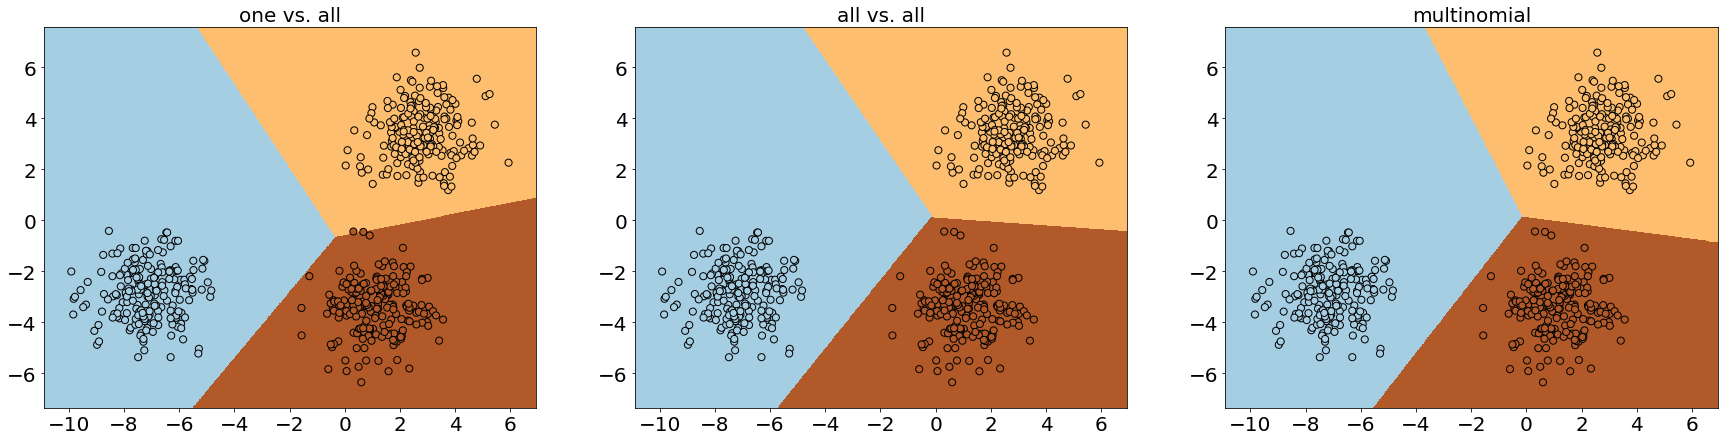

In [541]:
# создадим окружение
fig, ax = plt.subplots()

# зададим размеры рисунка
fig.set_figwidth(30)
fig.set_figheight(7)

# подпись ко всему
#plt.suptitle('GDC vs. SGDC', fontsize=30)

plt.subplot(1, 3, 1)
h = .02 

x_min, x_max = X_mult[:, 1].min() - 1, X_mult[:, 1].max() + 1
y_min, y_max = X_mult[:, 2].min() - 1, X_mult[:, 2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = one_vs_all_classifier.predict(np.hstack((np.ones((np.c_[xx.ravel(), yy.ravel()].shape[0], 1)), np.c_[xx.ravel(), yy.ravel()])))

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X_mult[:, 1], X_mult[:, 2], c=y_mult, cmap=plt.cm.Paired, edgecolors='k', s=50)
plt.title('one vs. all', fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.subplot(1, 3, 3)
h = .02 

x_min, x_max = X_mult[:, 1].min() - 1, X_mult[:, 1].max() + 1
y_min, y_max = X_mult[:, 2].min() - 1, X_mult[:, 2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = multiclass_classifier.predict(np.hstack((np.ones((np.c_[xx.ravel(), yy.ravel()].shape[0], 1)), np.c_[xx.ravel(), yy.ravel()])))

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X_mult[:, 1], X_mult[:, 2], c=y_mult, cmap=plt.cm.Paired, edgecolors='k', s=50)
plt.title('multinomial', fontsize=20)
plt.axis('tight')


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.subplot(1, 3, 2)
h = .02 

x_min, x_max = X_mult[:, 1].min() - 1, X_mult[:, 1].max() + 1
y_min, y_max = X_mult[:, 2].min() - 1, X_mult[:, 2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = all_vs_all_classifier.predict(np.hstack((np.ones((np.c_[xx.ravel(), yy.ravel()].shape[0], 1)), np.c_[xx.ravel(), yy.ravel()])))


# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X_mult[:, 1], X_mult[:, 2], c=y_mult, cmap=plt.cm.Paired, edgecolors='k', s=50)
plt.title('all vs. all', fontsize=20)
plt.axis('tight')


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


# сохранить
plt.savefig('Multiclass_other.pdf', bbox_inches='tight')

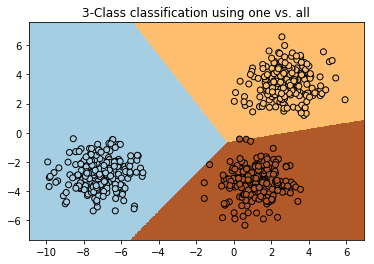

In [538]:
# создадим окружение
fig_2, ax = plt.subplots()

# заголовок рисунка
h = .02 

x_min, x_max = X_mult[:, 1].min() - 1, X_mult[:, 1].max() + 1
y_min, y_max = X_mult[:, 2].min() - 1, X_mult[:, 2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = one_vs_all_classifier.predict(np.hstack((np.ones((np.c_[xx.ravel(), yy.ravel()].shape[0], 1)), np.c_[xx.ravel(), yy.ravel()])))

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X_mult[:, 1], X_mult[:, 2], c=y_mult, cmap=plt.cm.Paired, edgecolors='k')
plt.title('3-Class classification using one vs. all')

#plt.savefig('3-Class classification using one vs all.pdf', bbox_inches='tight')


(-10.90762389150367, 6.9323761084959497, -7.348492464667034, 7.571507535332648)

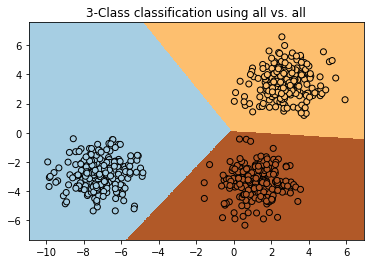

In [539]:
# создадим окружение
fig_2, ax = plt.subplots()

h = .02 

x_min, x_max = X_mult[:, 1].min() - 1, X_mult[:, 1].max() + 1
y_min, y_max = X_mult[:, 2].min() - 1, X_mult[:, 2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = all_vs_all_classifier.predict(np.hstack((np.ones((np.c_[xx.ravel(), yy.ravel()].shape[0], 1)), np.c_[xx.ravel(), yy.ravel()])))


# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X_mult[:, 1], X_mult[:, 2], c=y_mult, cmap=plt.cm.Paired, edgecolors='k')
plt.title('3-Class classification using all vs. all')
plt.axis('tight')

#plt.savefig('3-Class classification using all vs all.pdf')


hello


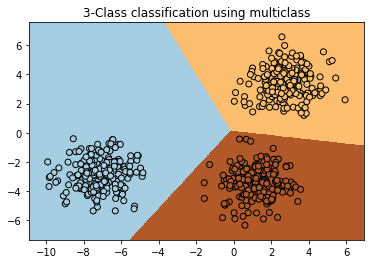

In [540]:
h = .02 

x_min, x_max = X_mult[:, 1].min() - 1, X_mult[:, 1].max() + 1
y_min, y_max = X_mult[:, 2].min() - 1, X_mult[:, 2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = multiclass_classifier.predict(np.hstack((np.ones((np.c_[xx.ravel(), yy.ravel()].shape[0], 1)), np.c_[xx.ravel(), yy.ravel()])))

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X_mult[:, 1], X_mult[:, 2], c=y_mult, cmap=plt.cm.Paired, edgecolors='k')
plt.title('3-Class classification using multiclass')
plt.axis('tight')
print('hello')
#plt.savefig('3-Class classification using multinomial.pdf')

6

Загрузить обучающую выборку датасета 20newsgroups при помощи метода sklearn.datasets.fetch_20newsgroups. Убрать все заголовки, подписи и цитаты, используя аргу- мент remove. Перевести во всех документах все буквы в нижний регистр. Заменить во всех документах символы, не являющиеся буквами и цифрами, на пробелы.


Замечание 1. Метод sklearn.datasets.fetch_20newsgroups может работать некорректно, если датасет уже содержится на диске.


Замечание 2. Полезные функции: str.lower, str.split, str.isalnum, re.sub, re.split.

In [4]:
from sklearn.datasets import fetch_20newsgroups

In [11]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

In [5]:
import re

In [13]:
for index in range(len(newsgroups_train.data)):
    newsgroups_train.data[index] = newsgroups_train.data[index].lower()
    newsgroups_train.data[index] = re.sub(r'\W', ' ', newsgroups_train.data[index])

7

Преобразовать датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j) означает, что в документе i слово j встретилось x раз. Разрешается воспользоваться конструктором sklearn.feature_extraction.text.CountVectorizer.

Замечание. Не забудьте потом учесть то, что число используемых токенов в тестовой выборке может отличаться от числа токенов в обучающей.

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
count_vectorizer = CountVectorizer()

In [16]:
X_train_20ng_counts = count_vectorizer.fit_transform(newsgroups_train.data)
type(X_train_20ng_counts)

scipy.sparse.csr.csr_matrix

8 

Произвести tf-idf преобразование датасета при помощи TfidfTransformer из модуля sklearn.feature_extraction.text, обученного по обучающей выборке. Используйте параметры по умолчанию.
Подберите параметры линейной модели при помощи кросс-валидации или отложенной выборки. Иссле- дуйте как влияет использование преобразования tf-idf на точность модели на кросс-валидации.

Замечание. Подбор параметров следует начинать с выбора step_alpha, который не приводит к переполне- нию и осцилированию значения функции, при небольшом batch_size и небольшом числе итераций. Затем необходимо подобрать batch_size, который может позволить оперативная память вашего компьютера. Далее можно подбирать оптимальное количество итераций, требуемую точность и step_beta. Коэффици- ент регуляризации можно настраивать в самом конце. Возможен и другой порядок подбора параметров алгоритма, возможно, даже более эффективный.

Замечание. Не стесняйтесь делать много итераций алгоритма!

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer

In [7]:
tfidf_transformer = TfidfTransformer()

In [19]:
X_train_20ng_tfidf = tfidf_transformer.fit_transform(X_train_20ng_counts)
type(X_train_20ng_tfidf)

scipy.sparse.csr.csr_matrix

Без использования tf-idf

In [20]:
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train_20ng_counts, \
                                                                    newsgroups_train.target, \
                                                                    train_size=0.75, \
                                                                    random_state=241)

In [21]:
X_train_val = hstack([csr_matrix(np.ones((X_train_val.shape[0], 1))), X_train_val], format='csr')
X_test_val = hstack([csr_matrix(np.ones((X_test_val.shape[0], 1))), X_test_val], format='csr')

In [22]:
history_alpha = []
accuracy_alpha = []

In [23]:
for alpha in {0.1, 1, 10, 100}:
    tp.send_text('alpha start')
    gdc_classifier_alpha = GDClassifier(loss_function='multiclass_logistic', \
                                          step_alpha=alpha, \
                                        l2_coef=0, \
                                        max_iter=1000)
    history = gdc_classifier_alpha.fit(X=X_train_val, y=y_train_val, trace=True)
    history_alpha.append(history)
    y_pred_alpha = gdc_classifier_alpha.predict(X_test_val)
    accuracy_alpha.append(accuracy_score(y_true=y_test_val, y_pred=y_pred_alpha))
tp.send_text('finished')

200

In [45]:
accuracy_alpha

[0.61505832449628839,
 0.66454577589254149,
 0.65252739483916578,
 0.64510427712972784]

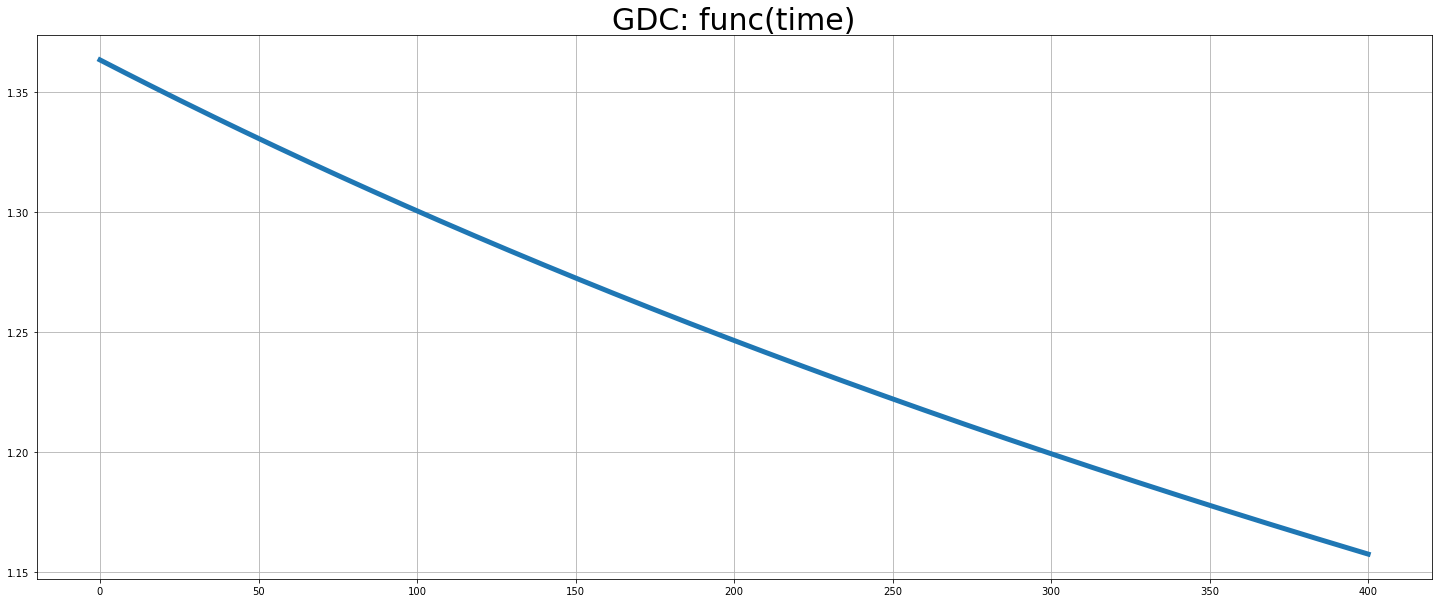

In [35]:
# создадим окружение
fig_2, ax = plt.subplots()

fig_2.set_figwidth(25)
fig_2.set_figheight(10)
plt.grid(True)

plt.title('GDC: func(time)', fontsize=30)
plt.plot(range(len(history_alpha[0]['func'][600:])), history_alpha[0]['func'][600:], '-', ms=5, linewidth=5)

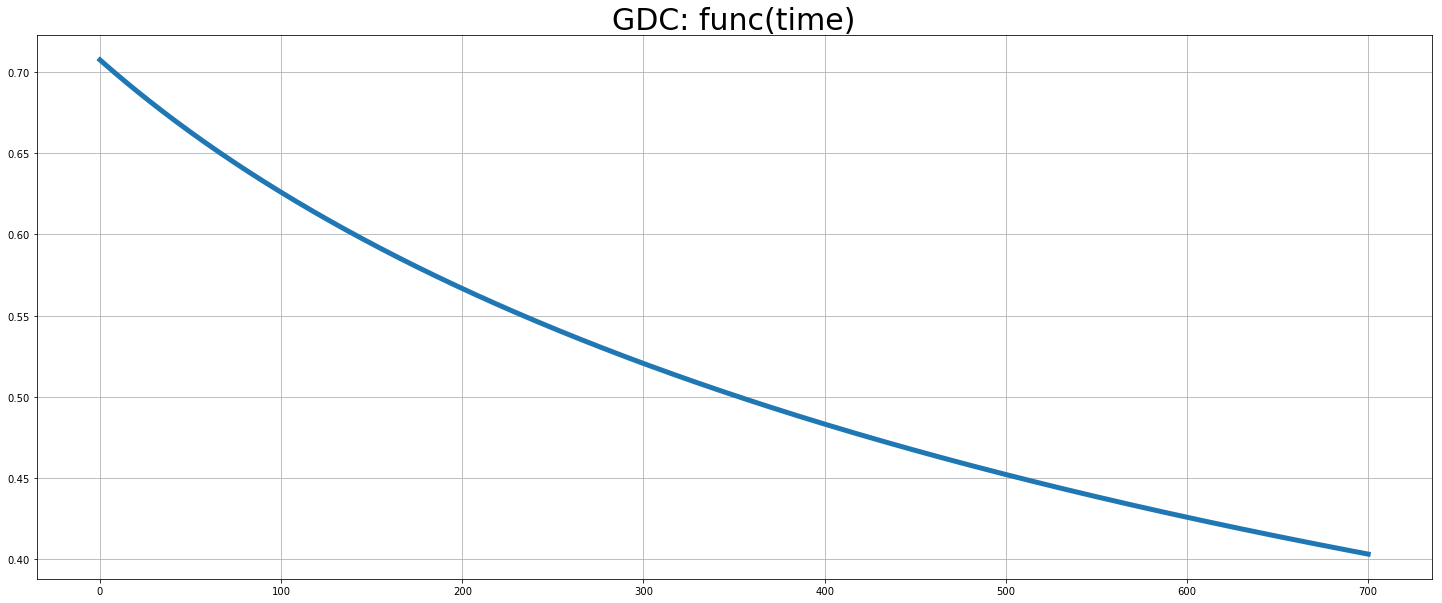

In [34]:
# создадим окружение
fig_2, ax = plt.subplots()

fig_2.set_figwidth(25)
fig_2.set_figheight(10)



plt.grid(True)

plt.title('GDC: func(time)', fontsize=30)
plt.plot(range(len(history_alpha[1]['func'][300:])), history_alpha[1]['func'][300:], '-', ms=5, linewidth=5)



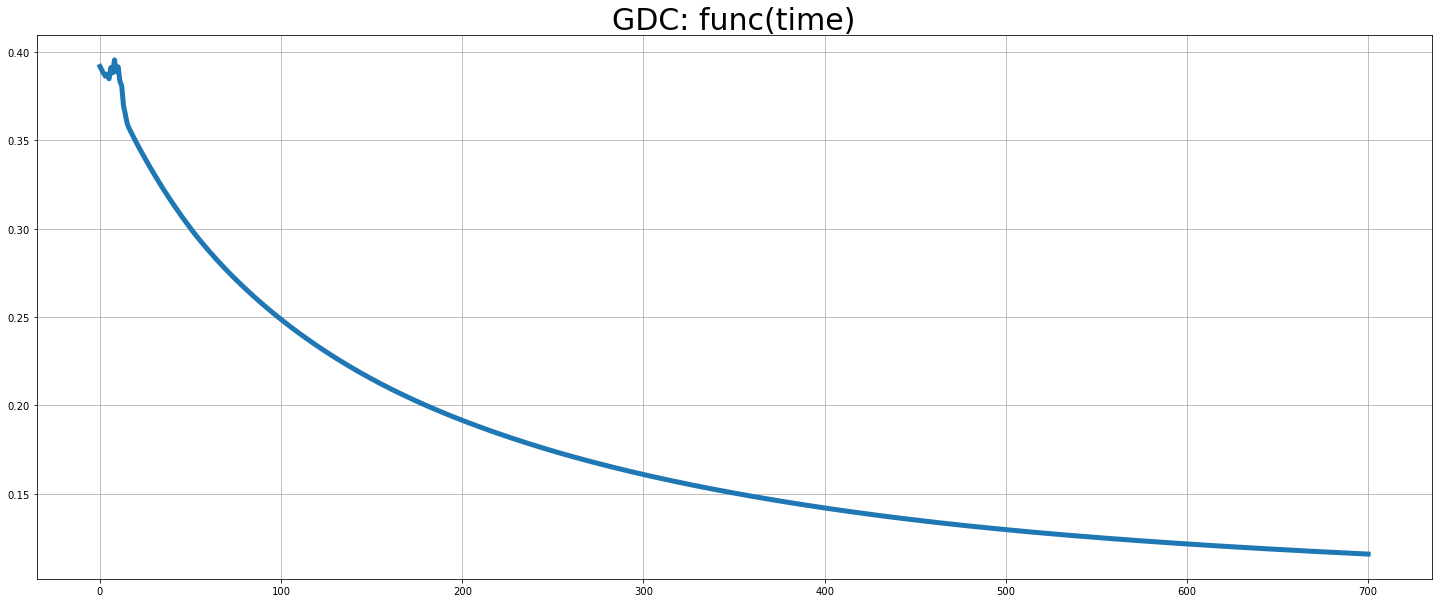

In [33]:
# создадим окружение
fig_2, ax = plt.subplots()

fig_2.set_figwidth(25)
fig_2.set_figheight(10)



plt.grid(True)

plt.title('GDC: func(time)', fontsize=30)
plt.plot(range(len(history_alpha[2]['func'][300:])), history_alpha[2]['func'][300:], '-', ms=5, linewidth=5)



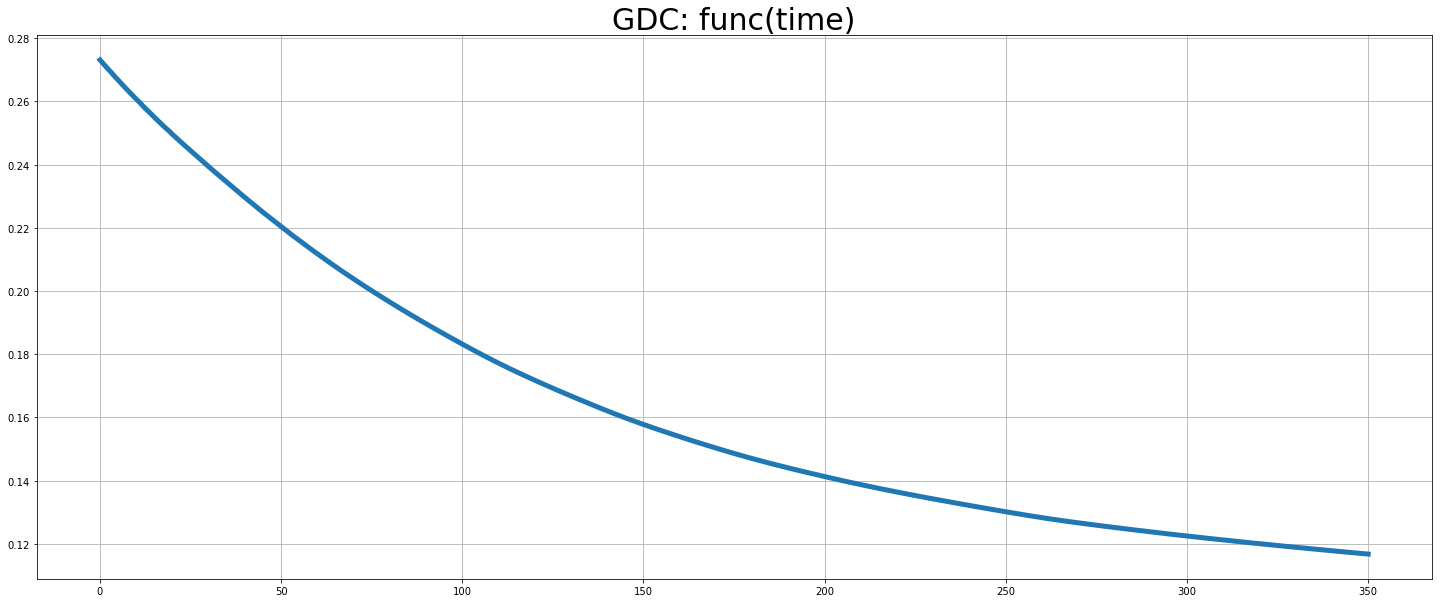

In [32]:
# создадим окружение
fig_2, ax = plt.subplots()

fig_2.set_figwidth(25)
fig_2.set_figheight(10)



plt.grid(True)

plt.title('GDC: func(time)', fontsize=30)
plt.plot(range(len(history_alpha[3]['func'][650:])), history_alpha[3]['func'][650:], '-', ms=5, linewidth=5)



In [36]:
accuracy_alpha

[0.61505832449628839,
 0.66454577589254149,
 0.65252739483916578,
 0.64510427712972784]

In [39]:
history_l2 = []
for l2_coef in {0, 1e-6, 1, 10}:
    tp.send_text('alpha start')
    gdc_classifier_alpha = GDClassifier(loss_function='multiclass_logistic', \
                                          step_alpha=100, \
                                          l2_coef=l2_coef,
                                        max_iter=1000)
    history = gdc_classifier_alpha.fit(X=X_train_val, y=y_train_val, trace=True)
    history_l2.append(history)
    y_pred_alpha = gdc_classifier_alpha.predict(X_test_val)
    print(accuracy_score(y_true=y_test_val, y_pred=y_pred_alpha))
tp.send_text('finished')

0.64510427713


/Users/Galya/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: overflow encountered in square
/Users/Galya/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in double_scalars


0.0410038882998
0.0530222693531
0.641569459173


200

In [40]:
for l2_coef in {1e-5, 1e-4, 1e-3, 1e-2, 1e-1}:
    tp.send_text('alpha start')
    gdc_classifier_alpha = GDClassifier(loss_function='multiclass_logistic', \
                                          step_alpha=100, \
                                          l2_coef=l2_coef,
                                        max_iter=1000)
    history = gdc_classifier_alpha.fit(X=X_train_val, y=y_train_val, trace=True)
    history_l2.append(history)
    y_pred_alpha = gdc_classifier_alpha.predict(X_test_val)
    print(accuracy_score(y_true=y_test_val, y_pred=y_pred_alpha))
tp.send_text('finished')

/Users/Galya/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: overflow encountered in square
/Users/Galya/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in double_scalars


0.0501944149876
0.413220219159
0.0813008130081
0.347119123365
0.106044538706


200

С использованием tf-idf

In [43]:
X_train_tf_idf, X_test_tf_idf, y_train_tf_idf, y_test_tf_idf = train_test_split(X_train_20ng_tfidf, \
                                                                    newsgroups_train.target, \
                                                                    train_size=0.75, \
                                                                    random_state=241)

In [44]:
X_train_tf_idf = hstack([csr_matrix(np.ones((X_train_tf_idf.shape[0], 1))), X_train_tf_idf], format='csr')
X_test_tf_idf = hstack([csr_matrix(np.ones((X_test_tf_idf.shape[0], 1))), X_test_tf_idf], format='csr')

In [46]:
history_with_tf_idf = []

for alpha in  {1, 10, 100}:
    tp.send_text('alpha start')
    gdc_classifier = GDClassifier(loss_function='multiclass_logistic', \
                                          step_alpha=alpha, \
                                          l2_coef=0, \
                                            max_iter=1000)
    history = gdc_classifier.fit(X=X_train_tf_idf, y=y_train_tf_idf, trace=True)
    history_with_tf_idf.append(history)
    y_pred_alpha = gdc_classifier.predict(X_test_tf_idf)
    print(accuracy_score(y_true=y_test_tf_idf, y_pred=y_pred_alpha))
tp.send_text('finished')

0.589961117002
0.713679745493
0.744432661718


200

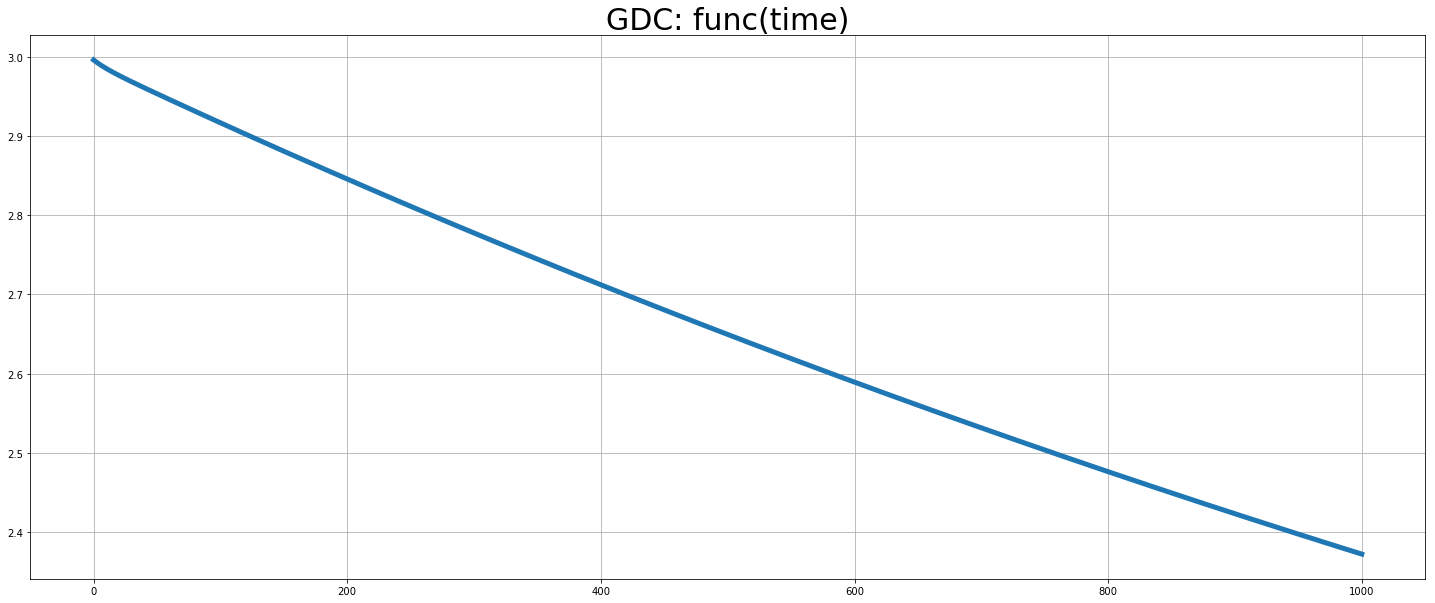

In [49]:
# создадим окружение
fig_2, ax = plt.subplots()

fig_2.set_figwidth(25)
fig_2.set_figheight(10)



plt.grid(True)

plt.title('GDC: func(time)', fontsize=30)
plt.plot(range(len(history_with_tf_idf[0]['func'])), history_with_tf_idf[0]['func'], '-', ms=5, linewidth=5)

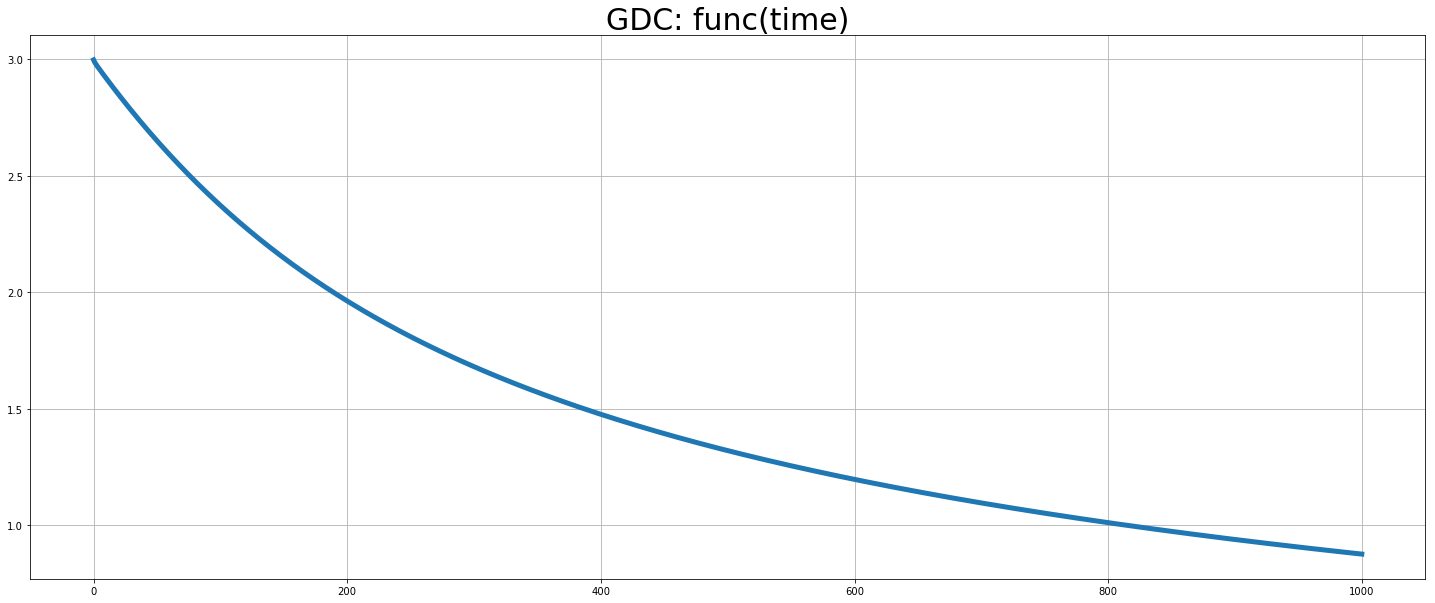

In [48]:
# создадим окружение
fig_2, ax = plt.subplots()

fig_2.set_figwidth(25)
fig_2.set_figheight(10)



plt.grid(True)

plt.title('GDC: func(time)', fontsize=30)
plt.plot(range(len(history_with_tf_idf[1]['func'])), history_with_tf_idf[1]['func'], '-', ms=5, linewidth=5)

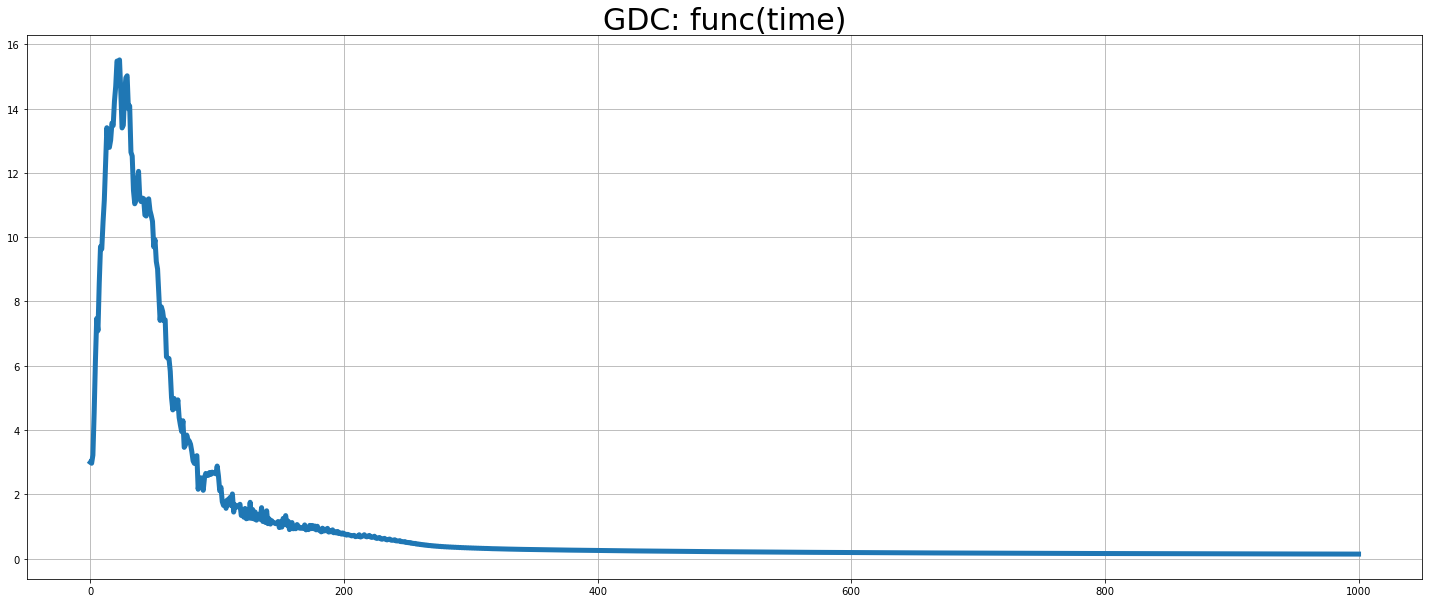

In [52]:
# создадим окружение
fig_2, ax = plt.subplots()

fig_2.set_figwidth(25)
fig_2.set_figheight(10)



plt.grid(True)

plt.title('GDC: func(time)', fontsize=30)
plt.plot(range(len(history_with_tf_idf[2]['func'])), history_with_tf_idf[2]['func'], '-', ms=5, linewidth=5)

In [53]:
tp.send_text('alpha start')
gdc_classifier = GDClassifier(loss_function='multiclass_logistic', \
                                          step_alpha=100, \
                                          l2_coef=1e-6,
                                        max_iter=1000)
history = gdc_classifier.fit(X=X_train_tf_idf, y=y_train_tf_idf, trace=True)

y_pred_alpha = gdc_classifier.predict(X_test_tf_idf)
print(accuracy_score(y_true=y_test_tf_idf, y_pred=y_pred_alpha))
tp.send_text('finished')

0.744079179922


200

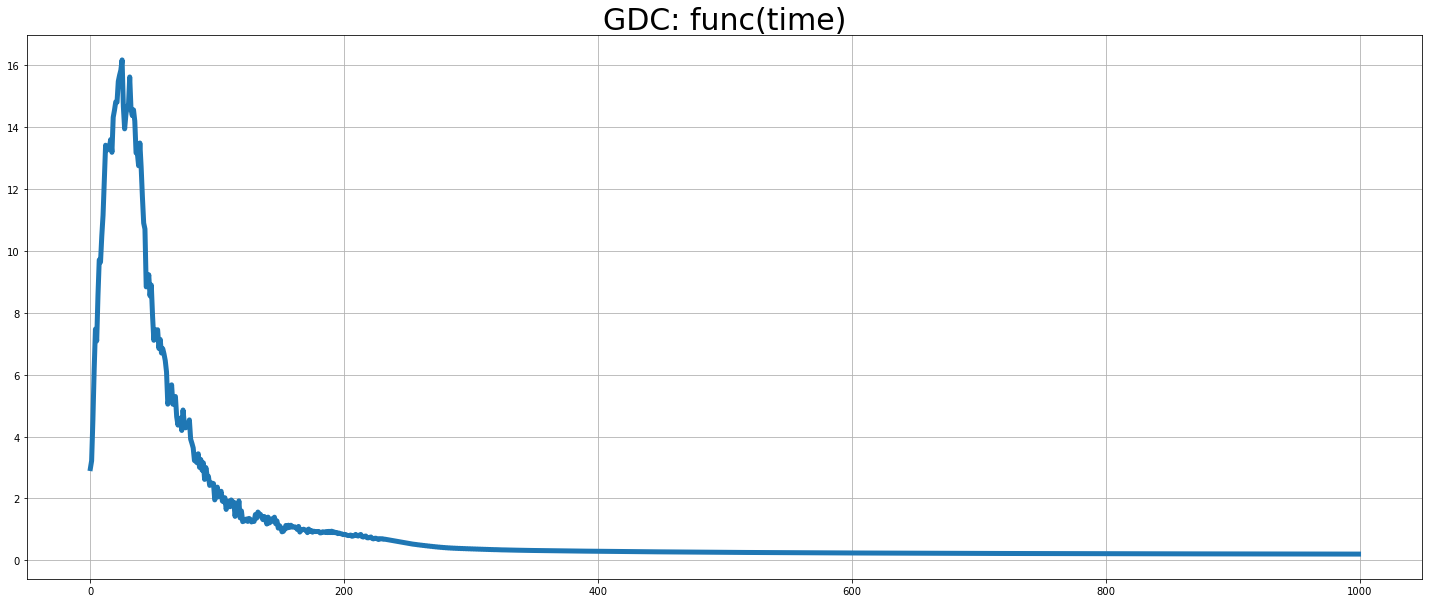

In [54]:
# создадим окружение
fig_2, ax = plt.subplots()

fig_2.set_figwidth(25)
fig_2.set_figheight(10)



plt.grid(True)

plt.title('GDC: func(time)', fontsize=30)
plt.plot(range(len(history['func']) - 1), history['func'][1:], '-', ms=5, linewidth=5)

9

Загрузите тестовую выборку (параметр subset метода fetch_20newsgroups). Примените лучший ал- горитм к тестовой выборке. Сравнить точность с полученной по кросс-валидации. Вывести несколь- ко документов из тестовой выборки, на которых были допущены ошибки. Проанализировать их. По- строить и проанализировать матрицу ошибок (confusion matrix). Можно воспользоваться функцией sklearn.metrics.confusion_matrix.

In [8]:
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [543]:
newsgroups_test_for_9 = fetch_20newsgroups(subset='test')

In [555]:
newsgroups_train_for_9 = fetch_20newsgroups(subset='train')

In [9]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

In [54]:
for index in range(len(newsgroups_test.data)):
    newsgroups_test.data[index] = newsgroups_test.data[index].lower()
    newsgroups_test.data[index] = re.sub(r'\W', ' ', newsgroups_test.data[index])

In [55]:
for index in range(len(newsgroups_train.data)):
    newsgroups_train.data[index] = newsgroups_train.data[index].lower()
    newsgroups_train.data[index] = re.sub(r'\W', ' ', newsgroups_train.data[index])

In [56]:
X_train_20ng_counts = count_vectorizer.fit_transform(newsgroups_train.data)
X_train_20ng_counts.shape

(11314, 101631)

In [57]:
X_test_20ng_counts = count_vectorizer.transform(newsgroups_test.data)
X_test_20ng_counts.shape

(7532, 101631)

In [58]:
X_train_20ng_tfidf = tfidf_transformer.fit_transform(X_train_20ng_counts)
X_train_20ng_tfidf.shape

(11314, 101631)

In [59]:
X_test_20ng_tfidf = tfidf_transformer.transform(X_test_20ng_counts)
X_test_20ng_tfidf.shape

(7532, 101631)

In [60]:
X_train_20ng_tfidf.shape

(11314, 101631)

In [61]:
X_test_20ng_tfidf = hstack([csr_matrix(np.ones((X_test_20ng_tfidf.shape[0], 1))), X_test_20ng_tfidf], format='csr')

In [62]:
X_train_20ng_tfidf = hstack([csr_matrix(np.ones((X_train_20ng_tfidf.shape[0], 1))), X_train_20ng_tfidf], format='csr')

In [63]:
X_test_20ng_tfidf.shape

(7532, 101632)

In [64]:
X_train_20ng_tfidf.shape

(11314, 101632)

In [576]:
tp.send_text('20ng start')
gdc_classifier_new = GDClassifier(loss_function='multiclass_logistic', \
                                          step_alpha=100, \
                                          l2_coef=1e-6,
                                        max_iter=2000)
%time gdc_classifier_new.fit(X=X_train_20ng_tfidf, \
                             y=newsgroups_train.target)
#history_with_tf_idf.append(history)
y_pred_9_new = gdc_classifier_new.predict(X_test_20ng_tfidf)
print(accuracy_score(y_true=newsgroups_test.target, y_pred=y_pred_9_new))
tp.send_text('20ng finished')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
CPU times: user 12min 7s, sys: 1min 13s, total: 13min 20s
Wall time: 13min 31s
0.683749336166


200

In [49]:
from sklearn.metrics import confusion_matrix

In [51]:
import itertools
class_names = np.unique(newsgroups_train.target_names)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Confusion matrix, without normalization
[[ 0  1  3  0  1  1  0 13  7  4  1  2  4  8 14 43  9 10  9 35]
 [ 5  0 20 10  6 19  6  8  3  7  0  5 10  2  8  1  2  1  3  1]
 [ 3 26  0 43 16 10  2 18  2  3  1  3  3  6  9  2  2  1  5  2]
 [ 2 15 34  0 27  7 11 10  0  0  1  1 28  1  2  0  0  0  1  0]
 [ 0  6 10 32  0  2 11 25  2  1  1  4 23  2  4  1  2  0  0  0]
 [ 0 48 33 10  3  0  3  6  1  1  0  4  5  1  5  3  1  1  0  2]
 [ 0  3  6 17 13  0  0 17  6  1  1  1  8  0  2  2  2  2  0  1]
 [ 6  1  3  2  1  0 10  0 15  7  2  1 18  2  6  1  4  3  7  2]
 [ 3  4  2  0  1  0  4 34  0  6  1  2 11  6  7  4  4  3  7  2]
 [ 4  2  0  0  2  2  5 21  6  0 20  0  1  4  2  6  1  2  7  0]
 [ 3  1  1  0  0  1  2 11  1 21  0  1  1  3  3  1  4  1  1  4]
 [ 4  4  7  3  4  2  5 20  4  4  4  0 13  3  7  2 13  5  8  8]
 [ 5 14 11 25 11  3 12 24 10  5  0 12  0 10 10  2  1  1  2  2]
 [ 8  9  1  1  1  0  3 26  6  0  3  1  7  0  4 10  3  5  7  3]
 [ 6 12  4  1  3  2  4 27  5  1  2  4 11  5  0  3  5  2 11  1]
 [22  3  2  0  

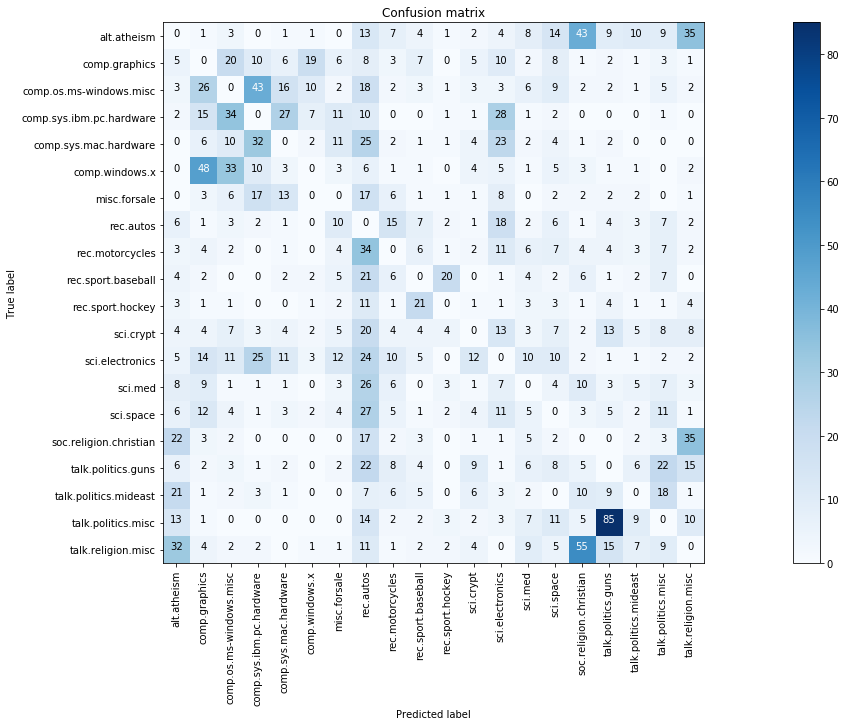

In [277]:

fig, ax = plt.subplots()

fig.set_figwidth(25)
fig.set_figheight(10)

cnf_matrix = confusion_matrix(y_true=newsgroups_test.target, y_pred=y_pred_9)
for i in range(class_names.shape[0]):
    cnf_matrix[i, i] = 0
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.savefig('conf_matrix_9.pdf', bbox_inches='tight')


plt.show()

In [93]:
newsgroups_test.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [553]:
newsgroups_test.target_names[18]

'talk.politics.misc'

In [570]:
print(np.array(newsgroups_test_for_9.data)[newsgroups_test.target != y_pred_9][0])
print(np.array(newsgroups_test.data)[newsgroups_test.target != y_pred_9][0])
print(np.array(newsgroups_test.target_names)[newsgroups_test.target][newsgroups_test.target != y_pred_9][0])
print(np.array(newsgroups_test.target_names)[y_pred_9][newsgroups_test.target != y_pred_9][0])

From: Rick Miller <rick@ee.uwm.edu>
Subject: X-Face?
Organization: Just me.
Lines: 17
Distribution: world
NNTP-Posting-Host: 129.89.2.33
Summary: Go ahead... swamp me.  <EEP!>

I'm not familiar at all with the format of these "X-Face:" thingies, but
after seeing them in some folks' headers, I've *got* to *see* them (and
maybe make one of my own)!

I've got "dpg-view" on my Linux box (which displays "uncompressed X-Faces")
and I've managed to compile [un]compface too... but now that I'm *looking*
for them, I can't seem to find any X-Face:'s in anyones news headers!  :-(

Could you, would you, please send me your "X-Face:" header?

I *know* I'll probably get a little swamped, but I can handle it.

	...I hope.

Rick Miller  <rick@ee.uwm.edu> | <ricxjo@discus.mil.wi.us>   Ricxjo Muelisto
Send a postcard, get one back! | Enposxtigu bildkarton kaj vi ricevos alion!
          RICK MILLER // 16203 WOODS // MUSKEGO, WIS. 53150 // USA

i m not familiar at all with the format of these  x face   t

In [569]:
print(np.array(newsgroups_test_for_9.data)[newsgroups_test.target != y_pred_9][1])
print(np.array(newsgroups_test.data)[newsgroups_test.target != y_pred_9][1])
print(np.array(newsgroups_test.target_names)[newsgroups_test.target][newsgroups_test.target != y_pred_9][1])
print(np.array(newsgroups_test.target_names)[y_pred_9][newsgroups_test.target != y_pred_9][1])

From: mathew <mathew@mantis.co.uk>
Subject: Re: STRONG & weak Atheism
Organization: Mantis Consultants, Cambridge. UK.
X-Newsreader: rusnews v1.02
Lines: 9

acooper@mac.cc.macalstr.edu (Turin Turambar, ME Department of Utter Misery) writes:
> Did that FAQ ever got modified to re-define strong atheists as not those who
> assert the nonexistence of God, but as those who assert that they BELIEVE in 
> the nonexistence of God?

In a word, yes.


mathew

 in a word  yes  
alt.atheism
talk.politics.misc


In [572]:
print(np.array(newsgroups_test_for_9.data)[newsgroups_test.target != y_pred_9][2])
print(np.array(newsgroups_test.data)[newsgroups_test.target != y_pred_9][2])
print(np.array(newsgroups_test.target_names)[newsgroups_test.target][newsgroups_test.target != y_pred_9][2])
print(np.array(newsgroups_test.target_names)[y_pred_9][newsgroups_test.target != y_pred_9][2])

From: bakken@cs.arizona.edu (Dave Bakken)
Subject: Re: Saudi clergy condemns debut of human rights group!
Keywords: international, non-usa government, government, civil rights, 	social issues, politics
Organization: U of Arizona CS Dept, Tucson
Lines: 101

In article <benali.737307554@alcor> benali@alcor.concordia.ca ( ILYESS B. BDIRA ) writes:
>It looks like Ben Baz's mind and heart are also blind, not only his eyes.
>I used to respect him, today I lost the minimal amount of respect that
>I struggled to keep for him.
>To All Muslim netters: This is the same guy who gave a "Fatwah" that
>Saudi Arabia can be used by the United Ststes to attack Iraq . 

They were attacking the Iraqis to drive them out of Kuwait,
a country whose citizens have close blood and business ties
to Saudi citizens.  And me thinks if the US had not helped out
the Iraqis would have swallowed Saudi Arabia, too (or at 
least the eastern oilfields).  And no Muslim country was doing
much of anything to help liberate Ku

10

Примените алгоритмы лемматизации и стемминга на датасете 20newsgroups (например, алгоритмы SnowballStemmer и WordNetLemmatizer из библиотеки nltk). Исследуйте как предобработка корпуса по- влияла на точность классификации, время работы алгоритма и размерность признакового пространства.


In [12]:
from nltk.stem import SnowballStemmer

In [13]:
stemmer = SnowballStemmer("english")

AttributeError: 'list' object has no attribute 'shape'

In [14]:
newsgroups_test_stemmed_data = list(newsgroups_test.data)
for index in range(len(newsgroups_test.data)):
    splited_text = newsgroups_test.data[index].split()
    newsgroups_test_stemmed_data[index] = " ".join([stemmer.stem(word) for word in splited_text])

In [15]:
newsgroups_train_stemmed_data = list(newsgroups_train.data)
for index in range(len(newsgroups_train.data)):
    splited_text = newsgroups_train.data[index].split()
    newsgroups_train_stemmed_data[index] = " ".join([stemmer.stem(word) for word in splited_text])

In [16]:
X_train_stemmed_counts = count_vectorizer.fit_transform(newsgroups_train_stemmed_data)
X_train_stemmed_counts.shape

(11314, 84435)

In [17]:
X_test_stemmed_counts = count_vectorizer.transform(newsgroups_test_stemmed_data)
X_test_stemmed_counts.shape

(7532, 84435)

In [18]:
X_train_stemmed_tfidf = tfidf_transformer.fit_transform(X_train_stemmed_counts)
X_train_stemmed_tfidf.shape

(11314, 84435)

In [19]:
X_test_stemmed_tfidf = tfidf_transformer.transform(X_test_stemmed_counts)
X_test_stemmed_tfidf.shape

(7532, 84435)

In [30]:
X_test_stemmed_tfidf = hstack([csr_matrix(np.ones((X_test_stemmed_tfidf.shape[0], 1))), X_test_stemmed_tfidf], format='csr')

In [31]:
X_train_stemmed_tfidf = hstack([csr_matrix(np.ones((X_train_stemmed_tfidf.shape[0], 1))), X_train_stemmed_tfidf], format='csr')

In [579]:
tp.send_text('stemmed start')
gdc_classifier = GDClassifier(loss_function='multiclass_logistic', \
                                          step_alpha=100, \
                                          l2_coef=1e-6,
                                        max_iter=3000)
%time gdc_classifier.fit(X=X_train_stemmed_tfidf, \
                             y=newsgroups_train.target)
#history_with_tf_idf.append(history)
y_pred_10_stemmed = gdc_classifier.predict(X_test_stemmed_tfidf)
print(accuracy_score(y_true=newsgroups_test.target, y_pred=y_pred_10_stemmed))
tp.send_text('stemmed finished')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
CPU times: user 10min 24s, sys: 1min 8s, total: 11min 32s
Wall time: 11min 41s
0.680430164631


200

С лемматизацией

In [34]:
from nltk.stem import WordNetLemmatizer


In [35]:
from nltk import wordnet

In [36]:
def get_wordnet_pos(treebank_tag):
    my_switch = {'J':wordnet.wordnet.ADJ,
                 'V':wordnet.wordnet.VERB,
                 'N':wordnet.wordnet.NOUN,
                 'R':wordnet.wordnet.ADV}
    for key, item in my_switch.items():
        if treebank_tag.startswith(key):
            return item
    return wordnet.wordnet.NOUN

In [37]:
import nltk
from nltk import pos_tag
wnl = WordNetLemmatizer()

In [38]:
newsgroups_test_lemmatized_data = list(newsgroups_test.data)
for index in range(len(newsgroups_test.data)):
    splited_text = newsgroups_test.data[index].split()
    pos_taged = [(word, get_wordnet_pos(tag)) for word, tag in pos_tag(splited_text)]
    newsgroups_test_lemmatized_data[index] = " ".join([wnl.lemmatize(word, tag) for word, tag in pos_taged])

In [39]:
newsgroups_train_lemmatized_data = list(newsgroups_train.data)
for index in range(len(newsgroups_train.data)):
    splited_text = newsgroups_train.data[index].split()
    pos_taged = [(word, get_wordnet_pos(tag)) for word, tag in pos_tag(splited_text)]
    newsgroups_train_lemmatized_data[index] = " ".join([wnl.lemmatize(word, tag) for word, tag in pos_taged])

In [40]:
tp.send_text('all finished!!!!')

200

In [41]:
X_train_lemmatized_counts = count_vectorizer.fit_transform(newsgroups_train_lemmatized_data)
X_train_lemmatized_counts.shape

(11314, 93650)

In [42]:
X_test_lemmatized_counts = count_vectorizer.transform(newsgroups_test_lemmatized_data)
X_test_lemmatized_counts.shape

(7532, 93650)

In [43]:
X_train_lemmatized_tfidf = tfidf_transformer.fit_transform(X_train_lemmatized_counts)
X_train_lemmatized_tfidf.shape

(11314, 93650)

In [44]:
X_test_lemmatized_tfidf = tfidf_transformer.transform(X_test_lemmatized_counts)
X_test_lemmatized_tfidf.shape

(7532, 93650)

In [45]:
X_test_lemmatized_tfidf = hstack([csr_matrix(np.ones((X_test_lemmatized_tfidf.shape[0], 1))), X_test_lemmatized_tfidf], format='csr')

In [46]:
X_train_lemmatized_tfidf = hstack([csr_matrix(np.ones((X_train_lemmatized_tfidf.shape[0], 1))), X_train_lemmatized_tfidf], format='csr')

In [578]:
tp.send_text('lemmatized start')
gdc_classifier = GDClassifier(loss_function='multiclass_logistic', \
                                          step_alpha=100, \
                                          l2_coef=1e-6,
                                        max_iter=2000)
%time gdc_classifier.fit(X=X_train_lemmatized_tfidf, \
                             y=newsgroups_train.target)
#history_with_tf_idf.append(history)
y_pred_10_lemmatized = gdc_classifier.predict(X_test_lemmatized_tfidf)
print(accuracy_score(y_true=newsgroups_test.target, y_pred=y_pred_10_lemmatized))
tp.send_text('lemmatized finished')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
CPU times: user 10min 32s, sys: 1min 8s, total: 11min 40s
Wall time: 11min 47s
0.685475305364


200

Confusion matrix, without normalization
[[ 0  1  1  0  0  1  0 10  3  2  1  2  3  8 11 39 11  8  9 41]
 [ 4  0 17  8  7 22  5  8  0  4  1  7 14  3  6  1  1  1  3  3]
 [ 4 26  0 38 18 13  5 19  3  0  0  3  3  6  8  4  2  2  4  4]
 [ 0 16 36  0 35  7 15  9  0  0  1  2 28  0  1  0  1  0  1  1]
 [ 1  6  8 31  0  3 11 22  3  1  1  4 17  2  6  0  1  1  0  0]
 [ 1 50 32 11  7  0  1  7  1  3  0  4  4  2  3  2  1  1  1  2]
 [ 0  3  3 16 14  0  0 16  6  3  0  1  8  0  3  1  2  4  0  0]
 [ 5  2  2  1  3  0 10  0 11  6  3  2 17  1  5  2  4  2  7  1]
 [ 2  3  3  2  2  1  7 38  0  6  1  2 11  9  5  1  4  3  7  2]
 [ 4  1  0  0  1  1  5 18  5  0 18  0  2  5  3  7  0  2  7  1]
 [ 1  1  2  0  0  1  0 12  1 19  0  0  2  4  3  1  5  2  2  3]
 [ 3  4  7  2  6  3  5 20  3  2  4  0 12  5  9  2 18  6  7  3]
 [ 3 12  9 20 17  2 21 24 10  4  0 15  0  9  8  3  1  1  2  2]
 [ 5  6  2  2  2  1  2 21  7  0  6  2 10  0  6  5  7  4  8  2]
 [ 8 14  2  1  4  2  3 28  5  0  0  4 15  9  0  3  3  1 14  1]
 [24  1  1  1  

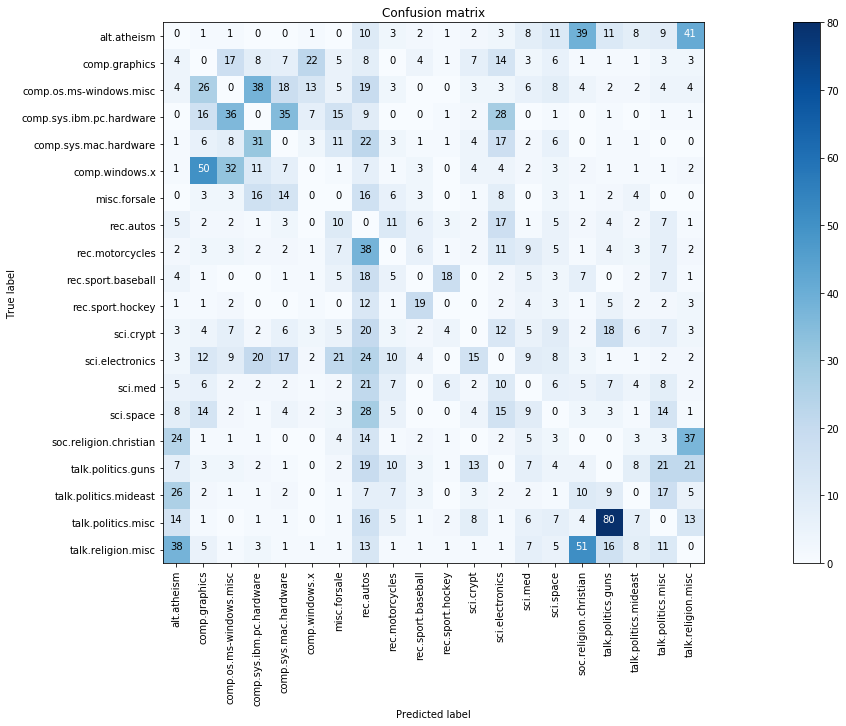

In [280]:
fig, ax = plt.subplots()

fig.set_figwidth(25)
fig.set_figheight(10)

cnf_matrix = confusion_matrix(y_true=newsgroups_test.target, y_pred=y_pred_10_stemmed)
for i in range(class_names.shape[0]):
    cnf_matrix[i, i] = 0
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.savefig('conf_matrix_10_stemmed.pdf', bbox_inches='tight')


plt.show()

Confusion matrix, without normalization
[[ 0  0  1  0  0  2  0 11  4  2  2  1  5  7 12 39 10  8  6 42]
 [ 4  0 17 10  8 21  6  7  1  8  0  6 11  1 10  1  1  1  0  1]
 [ 4 23  0 42 19 16  5 20  2  2  1  3  2  4  9  3  2  3  4  2]
 [ 0 14 39  0 28  7 13  9  0  0  1  3 29  0  1  0  0  0  0  0]
 [ 0  6  6 30  0  2 10 23  3  0  1  3 18  2  6  1  1  0  0  1]
 [ 1 48 29  8  2  0  4  7  3  4  0  4  4  0  2  2  1  1  0  0]
 [ 0  2  4 17 14  0  0 16  8  0  0  1  7  0  2  2  2  2  1  0]
 [ 4  3  2  2  1  0 12  0 13  5  4  2 19  2  3  1  2  4  8  2]
 [ 4  2  2  2  2  1  6 41  0  7  2  2 11  5  8  2  4  4  7  2]
 [ 3  1  1  1  1  1  5 19  6  0 17  0  1  5  3  6  1  2  7  1]
 [ 4  1  1  0  0  1  0 12  0 19  0  1  2  4  1  1  4  3  0  4]
 [ 4  4  6  2  6  4  4 24  2  5  3  0 12  1  5  4 16  6 10  4]
 [ 4 12 14 19 17  3 17 21  8  5  0 14  0  7  8  3  1  1  1  2]
 [ 8  7  3  2  1  2  1 19  7  0  4  3 10  0  3  5  4  3  6  3]
 [ 8 13  2  1  2  0  3 26  4  0  0  3 15 12  0  2  4  1 12  2]
 [24  2  2  0  

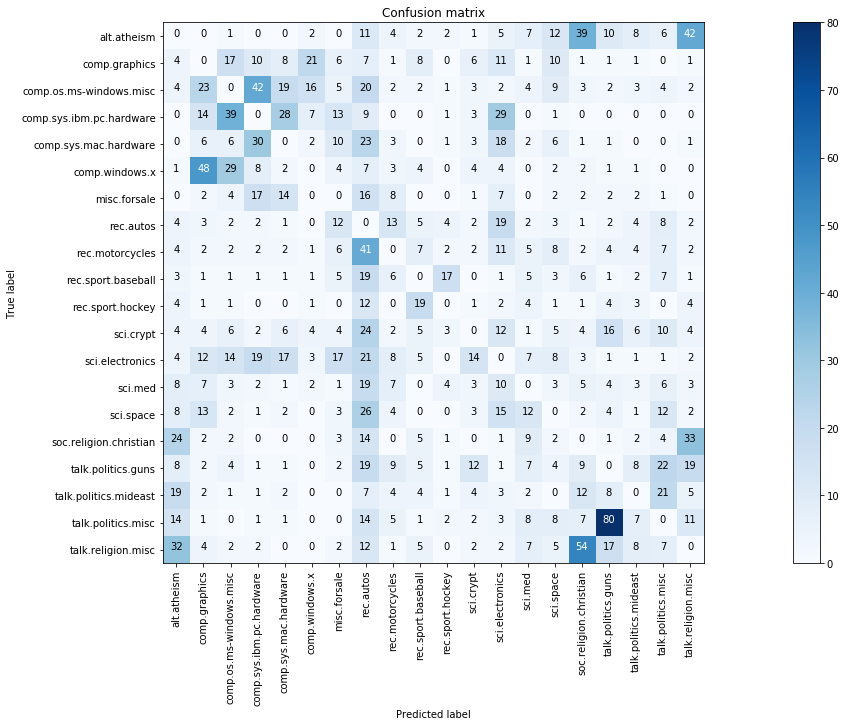

In [278]:
fig, ax = plt.subplots()

fig.set_figwidth(25)
fig.set_figheight(10)

cnf_matrix = confusion_matrix(y_true=newsgroups_test.target, y_pred=y_pred_10_lemmatized)
for i in range(class_names.shape[0]):
    cnf_matrix[i, i] = 0
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.savefig('conf_matrix_10_lemmatized.pdf', bbox_inches='tight')


plt.show()

11

Попробуйте ускорить работу алгоритма за счёт сокращения словаря. Удалите самые частотные слова и самые редкие. Исследуйте как зависит качество и время работы алгоритма от:

• Сколько было выброшено частотных слов 

• Сколько было выброшено редких слов


Исследуйте, как имениться качество алгоритма и время его работы, если вместо частотных слов выбра- сывать стоп-слова (воспользуйтесь функцией stopwords.words из модуля nltk).

In [98]:
count_vectorizer_001_099 = CountVectorizer(min_df=0.01, max_df=0.99)
count_vectorizer_01_099 = CountVectorizer(min_df=0.1, max_df=0.99)
count_vectorizer_001_09 = CountVectorizer(min_df=0.01, max_df=0.9)
count_vectorizer_01_09 = CountVectorizer(min_df=0.1, max_df=0.9)
count_vectorizer_0_099 = CountVectorizer(max_df=0.99)
count_vectorizer_001_100 = CountVectorizer(min_df=0.01)

In [99]:
X_train_counts_001_099 = count_vectorizer_001_099.fit_transform(newsgroups_train_lemmatized_data)

In [100]:
X_test_counts_001_099 = count_vectorizer_001_099.transform(newsgroups_test_lemmatized_data)

In [101]:
X_train_tfidf_001_099 = tfidf_transformer.fit_transform(X_train_counts_001_099)

In [102]:
X_test_tfidf_001_099 = tfidf_transformer.transform(X_test_counts_001_099)

In [103]:
X_test_tfidf_001_099 = hstack([csr_matrix(np.ones((X_test_tfidf_001_099.shape[0], 1))), X_test_tfidf_001_099], format='csr')

In [104]:
X_train_tfidf_001_099 = hstack([csr_matrix(np.ones((X_train_tfidf_001_099.shape[0], 1))), X_train_tfidf_001_099], format='csr')

In [105]:
tp.send_text('001 099 start')
gdc_classifier = GDClassifier(loss_function='multiclass_logistic', \
                                          step_alpha=100, \
                                          l2_coef=1e-6,
                                        max_iter=2000)
history = gdc_classifier.fit(X=X_train_tfidf_001_099, \
                             y=newsgroups_train.target)
#history_with_tf_idf.append(history)
y_pred_11_001_099 = gdc_classifier.predict(X_test_tfidf_001_099)
print(accuracy_score(y_true=newsgroups_test.target, y_pred=y_pred_11_001_099))
tp.send_text('001 099 finished')

0.493892724376


200

In [106]:
X_train_counts_01_099 = count_vectorizer_01_099.fit_transform(newsgroups_train_lemmatized_data)

In [107]:
X_test_counts_01_099 = count_vectorizer_01_099.transform(newsgroups_test_lemmatized_data)

In [108]:
X_train_tfidf_01_099 = tfidf_transformer.fit_transform(X_train_counts_01_099)

In [109]:
X_test_tfidf_01_099 = tfidf_transformer.transform(X_test_counts_01_099)

In [110]:
X_test_tfidf_01_099 = hstack([csr_matrix(np.ones((X_test_tfidf_01_099.shape[0], 1))), X_test_tfidf_01_099], format='csr')

In [111]:
X_train_tfidf_01_099 = hstack([csr_matrix(np.ones((X_train_tfidf_01_099.shape[0], 1))), X_train_tfidf_01_099], format='csr')

In [112]:
tp.send_text('01 099 start')
#gdc_classifier = GDClassifier(loss_function='multiclass_logistic', \
 #                                         step_alpha=100, \
 #                                         l2_coef=1e-6,
  #                                      max_iter=2000)
history = gdc_classifier.fit(X=X_train_tfidf_01_099, \
                             y=newsgroups_train.target)
#history_with_tf_idf.append(history)
y_pred_11_01_099 = gdc_classifier.predict(X_test_tfidf_01_099)
print(accuracy_score(y_true=newsgroups_test.target, y_pred=y_pred_11_01_099))
tp.send_text('01 099 finished')

0.145246946362


200

In [113]:
X_train_counts_001_09 = count_vectorizer_001_09.fit_transform(newsgroups_train_lemmatized_data)

In [114]:
X_test_counts_001_09 = count_vectorizer_001_09.transform(newsgroups_test_lemmatized_data)

In [115]:
X_train_tfidf_001_09 = tfidf_transformer.fit_transform(X_train_counts_001_09)

In [116]:
X_test_tfidf_001_09 = tfidf_transformer.transform(X_test_counts_001_09)

In [117]:
X_test_tfidf_001_09 = hstack([csr_matrix(np.ones((X_test_tfidf_001_09.shape[0], 1))), X_test_tfidf_001_09], format='csr')

In [118]:
X_train_tfidf_001_09 = hstack([csr_matrix(np.ones((X_train_tfidf_001_09.shape[0], 1))), X_train_tfidf_001_09], format='csr')

In [119]:
tp.send_text('001 09 start')
gdc_classifier = GDClassifier(loss_function='multiclass_logistic', \
                                          step_alpha=100, \
                                          l2_coef=1e-6,
                                        max_iter=2000)
history = gdc_classifier.fit(X=X_train_tfidf_001_09, \
                             y=newsgroups_train.target)
#history_with_tf_idf.append(history)
y_pred_11_001_09 = gdc_classifier.predict(X_test_tfidf_001_09)
print(accuracy_score(y_true=newsgroups_test.target, y_pred=y_pred_11_001_09))
tp.send_text('001 09 finished')

0.493892724376


200

In [120]:
X_train_counts_01_09 = count_vectorizer_01_09.fit_transform(newsgroups_train_lemmatized_data)

In [121]:
X_test_counts_01_09 = count_vectorizer_01_09.transform(newsgroups_test_lemmatized_data)

In [122]:
X_train_tfidf_01_09 = tfidf_transformer.fit_transform(X_train_counts_01_09)

In [123]:
X_test_tfidf_01_09 = tfidf_transformer.transform(X_test_counts_01_09)

In [124]:
X_test_tfidf_01_09 = hstack([csr_matrix(np.ones((X_test_tfidf_01_09.shape[0], 1))), X_test_tfidf_01_09], format='csr')

In [125]:
X_train_tfidf_01_09 = hstack([csr_matrix(np.ones((X_train_tfidf_01_09.shape[0], 1))), X_train_tfidf_01_09], format='csr')

In [126]:
tp.send_text('01 09 start')
gdc_classifier = GDClassifier(loss_function='multiclass_logistic', \
                                          step_alpha=100, \
                                          l2_coef=1e-6,
                                        max_iter=2000)
history = gdc_classifier.fit(X=X_train_tfidf_01_09, \
                             y=newsgroups_train.target)
#history_with_tf_idf.append(history)
y_pred_11_01_09 = gdc_classifier.predict(X_test_tfidf_01_09)
print(accuracy_score(y_true=newsgroups_test.target, y_pred=y_pred_11_01_09))
tp.send_text('01 09 finished')

0.145246946362


200

In [127]:
X_train_counts_0_099 = count_vectorizer_0_099.fit_transform(newsgroups_train_lemmatized_data)

In [128]:
X_test_counts_0_099 = count_vectorizer_0_099.transform(newsgroups_test_lemmatized_data)

In [129]:
X_train_tfidf_0_099 = tfidf_transformer.fit_transform(X_train_counts_0_099)

In [130]:
X_test_tfidf_0_099 = tfidf_transformer.transform(X_test_counts_0_099)

In [131]:
X_test_tfidf_0_099 = hstack([csr_matrix(np.ones((X_test_tfidf_0_099.shape[0], 1))), X_test_tfidf_0_099], format='csr')

In [132]:
X_train_tfidf_0_099 = hstack([csr_matrix(np.ones((X_train_tfidf_0_099.shape[0], 1))), X_train_tfidf_0_099], format='csr')

In [134]:
tp.send_text('0 099 start')
#gdc_classifier = GDClassifier(loss_function='multiclass_logistic', \
 #                                         step_alpha=100, \
  #                                        l2_coef=1e-6,
   #                                     max_iter=2000)
history = gdc_classifier.fit(X=X_train_tfidf_0_099, \
                             y=newsgroups_train.target)
#history_with_tf_idf.append(history)
y_pred_11_0_099 = gdc_classifier.predict(X_test_tfidf_0_099)
print(accuracy_score(y_true=newsgroups_test.target, y_pred=y_pred_11_0_099))
tp.send_text('0 099 finished')

0.685475305364


200

In [135]:
X_train_counts_001_0 = count_vectorizer_001_0.fit_transform(newsgroups_train_lemmatized_data)

In [136]:
X_test_counts_001_0 = count_vectorizer_001_0.transform(newsgroups_test_lemmatized_data)

In [137]:
X_train_tfidf_001_0 = tfidf_transformer.fit_transform(X_train_counts_001_0)

In [138]:
X_test_tfidf_001_0 = tfidf_transformer.transform(X_test_counts_001_0)

In [139]:
X_test_tfidf_001_0 = hstack([csr_matrix(np.ones((X_test_tfidf_001_0.shape[0], 1))), X_test_tfidf_001_0], format='csr')

In [140]:
X_train_tfidf_001_0 = hstack([csr_matrix(np.ones((X_train_tfidf_001_0.shape[0], 1))), X_train_tfidf_001_0], format='csr')

In [141]:
tp.send_text('001 0 start')
#gdc_classifier = GDClassifier(loss_function='multiclass_logistic', \
#                                          step_alpha=100, \
 #                                         l2_coef=1e-6,
 #                                       max_iter=2000)
history = gdc_classifier.fit(X=X_train_tfidf_001_0, \
                             y=newsgroups_train.target)
#history_with_tf_idf.append(history)
y_pred_11_001_0 = gdc_classifier.predict(X_test_tfidf_001_0)
print(accuracy_score(y_true=newsgroups_test.target, y_pred=y_pred_11_001_0))
tp.send_text('001 0 finished')

0.493892724376


200

In [142]:
count_vectorizer_0001_0999 = CountVectorizer(min_df=0.001, max_df=0.999)


In [143]:
X_train_counts_0001_0999 = count_vectorizer_0001_0999.fit_transform(newsgroups_train_lemmatized_data)

In [144]:
X_test_counts_0001_0999 = count_vectorizer_0001_0999.transform(newsgroups_test_lemmatized_data)

In [145]:
X_train_tfidf_0001_0999 = tfidf_transformer.fit_transform(X_train_counts_0001_0999)

In [146]:
X_test_tfidf_0001_0999 = tfidf_transformer.transform(X_test_counts_0001_0999)

In [147]:
X_test_tfidf_0001_0999 = hstack([csr_matrix(np.ones((X_test_tfidf_0001_0999.shape[0], 1))), X_test_tfidf_0001_0999], format='csr')

In [148]:
X_train_tfidf_0001_0999 = hstack([csr_matrix(np.ones((X_train_tfidf_0001_0999.shape[0], 1))), X_train_tfidf_0001_0999], format='csr')

In [252]:
tp.send_text('0001_0999 start')

#gdc_classifier = GDClassifier(loss_function='multiclass_logistic', \
#                                          step_alpha=100, \
 #                                         l2_coef=1e-6,
 #                                       max_iter=2000)
%time gdc_classifier.fit(X=X_train_tfidf_0001_0999, \
                             y=newsgroups_train.target)
#history_with_tf_idf.append(history)
y_pred_11_0001_0999 = gdc_classifier.predict(X_test_tfidf_0001_0999)
print(accuracy_score(y_true=newsgroups_test.target, y_pred=y_pred_11_0001_0999))
tp.send_text('0001_0999 finished')

CPU times: user 57.5 s, sys: 3.08 s, total: 1min
Wall time: 1min 1s
0.662108337759


200

In [150]:
count_vectorizer_001_0999 = CountVectorizer(min_df=0.01, max_df=0.999)


In [151]:
X_train_counts_001_0999 = count_vectorizer_001_0999.fit_transform(newsgroups_train_lemmatized_data)

In [152]:
X_test_counts_001_0999 = count_vectorizer_001_0999.transform(newsgroups_test_lemmatized_data)

In [153]:
X_train_tfidf_001_0999 = tfidf_transformer.fit_transform(X_train_counts_001_0999)

In [154]:
X_test_tfidf_001_0999 = tfidf_transformer.transform(X_test_counts_001_0999)

In [155]:
X_test_tfidf_001_0999 = hstack([csr_matrix(np.ones((X_test_tfidf_001_0999.shape[0], 1))), X_test_tfidf_001_0999], format='csr')

In [156]:
X_train_tfidf_001_0999 = hstack([csr_matrix(np.ones((X_train_tfidf_001_0999.shape[0], 1))), X_train_tfidf_001_0999], format='csr')

In [253]:
tp.send_text('001_0999 start')
#gdc_classifier = GDClassifier(loss_function='multiclass_logistic', \
#                                          step_alpha=100, \
 #                                         l2_coef=1e-6,
 #                                       max_iter=2000)
%time gdc_classifier.fit(X=X_train_tfidf_001_0999, \
                             y=newsgroups_train.target)
#history_with_tf_idf.append(history)
y_pred_11_001_0999 = gdc_classifier.predict(X_test_tfidf_001_0999)
print(accuracy_score(y_true=newsgroups_test.target, y_pred=y_pred_11_001_0999))
tp.send_text('001_0999 finished')

CPU times: user 2min 7s, sys: 5.07 s, total: 2min 12s
Wall time: 2min 14s
0.493892724376


200

In [158]:
count_vectorizer_0_0999 = CountVectorizer(max_df=0.999)


In [159]:
X_train_counts_0_0999 = count_vectorizer_0_0999.fit_transform(newsgroups_train_lemmatized_data)

In [160]:
X_test_counts_0_0999 = count_vectorizer_0_0999.transform(newsgroups_test_lemmatized_data)

In [161]:
X_train_tfidf_0_0999 = tfidf_transformer.fit_transform(X_train_counts_0_0999)

In [162]:
X_test_tfidf_0_0999 = tfidf_transformer.transform(X_test_counts_0_0999)

In [163]:
X_test_tfidf_0_0999 = hstack([csr_matrix(np.ones((X_test_tfidf_0_0999.shape[0], 1))), X_test_tfidf_0_0999], format='csr')

In [164]:
X_train_tfidf_0_0999 = hstack([csr_matrix(np.ones((X_train_tfidf_0_0999.shape[0], 1))), X_train_tfidf_0_0999], format='csr')

In [183]:

tp.send_text('0_0999 start')
#gdc_classifier = GDClassifier(loss_function='multiclass_logistic', \
#                                          step_alpha=100, \
 #                                         l2_coef=1e-6,
 #                                       max_iter=2000)
%time gdc_classifier.fit(X=X_train_tfidf_0_0999, \
                             y=newsgroups_train.target)
#history_with_tf_idf.append(history)
y_pred_11_0_0999 = gdc_classifier.predict(X_test_tfidf_0_0999)
print(accuracy_score(y_true=newsgroups_test.target, y_pred=y_pred_11_0_0999))
tp.send_text('0_0999 finished')

KeyboardInterrupt: 

In [168]:
count_vectorizer_0001_099 = CountVectorizer(min_df=0.001, max_df=0.99)


In [169]:
X_train_counts_0001_099 = count_vectorizer_0001_099.fit_transform(newsgroups_train_lemmatized_data)

In [170]:
X_test_counts_0001_099 = count_vectorizer_0001_099.transform(newsgroups_test_lemmatized_data)

In [171]:
X_train_tfidf_0001_099 = tfidf_transformer.fit_transform(X_train_counts_0001_099)

In [172]:
X_test_tfidf_0001_099 = tfidf_transformer.transform(X_test_counts_0001_099)

In [173]:
X_test_tfidf_0001_099 = hstack([csr_matrix(np.ones((X_test_tfidf_0001_099.shape[0], 1))), X_test_tfidf_0001_099], format='csr')

In [174]:
X_train_tfidf_0001_099 = hstack([csr_matrix(np.ones((X_train_tfidf_0001_099.shape[0], 1))), X_train_tfidf_0001_099], format='csr')

In [254]:
tp.send_text('0001_099 start')
#gdc_classifier = GDClassifier(loss_function='multiclass_logistic', \
#                                          step_alpha=100, \
 #                                         l2_coef=1e-6,
 #                                       max_iter=2000)
%time gdc_classifier.fit(X=X_train_tfidf_0001_099, \
                             y=newsgroups_train.target)
#history_with_tf_idf.append(history)
y_pred_11_0001_099 = gdc_classifier.predict(X_test_tfidf_0001_099)
print(accuracy_score(y_true=newsgroups_test.target, y_pred=y_pred_11_0001_099))
tp.send_text('0001_099 finished')

CPU times: user 54.7 s, sys: 3.01 s, total: 57.7 s
Wall time: 58 s
0.662108337759


200

In [184]:
count_vectorizer_0_09 = CountVectorizer(max_df=0.9)



In [185]:
X_train_counts_0_09 = count_vectorizer_0_09.fit_transform(newsgroups_train_lemmatized_data)

In [186]:
X_test_counts_0_09 = count_vectorizer_0_09.transform(newsgroups_test_lemmatized_data)

In [187]:
X_train_tfidf_0_09 = tfidf_transformer.fit_transform(X_train_counts_0_09)

In [188]:
X_test_tfidf_0_09 = tfidf_transformer.transform(X_test_counts_0_09)

In [189]:
X_test_tfidf_0_09 = hstack([csr_matrix(np.ones((X_test_tfidf_0_09.shape[0], 1))), X_test_tfidf_0_09], format='csr')

In [190]:
X_train_tfidf_0_09 = hstack([csr_matrix(np.ones((X_train_tfidf_0_09.shape[0], 1))), X_train_tfidf_0_09], format='csr')

In [192]:
tp.send_text('0 09 start')
#gdc_classifier = GDClassifier(loss_function='multiclass_logistic', \
 #                                         step_alpha=100, \
  #                                        l2_coef=1e-6,
   #                                     max_iter=2000)
gdc_classifier.fit(X=X_train_tfidf_0_09, \
                             y=newsgroups_train.target)
#history_with_tf_idf.append(history)
y_pred_11_0_09 = gdc_classifier.predict(X_test_tfidf_0_09)
print(accuracy_score(y_true=newsgroups_test.target, y_pred=y_pred_11_0_09))
tp.send_text('0 09 finished')

0.685475305364


200

In [193]:
count_vectorizer_0_08 = CountVectorizer(max_df=0.8)



In [194]:
X_train_counts_0_08 = count_vectorizer_0_08.fit_transform(newsgroups_train_lemmatized_data)

In [195]:
X_test_counts_0_08 = count_vectorizer_0_08.transform(newsgroups_test_lemmatized_data)

In [196]:
X_train_tfidf_0_08 = tfidf_transformer.fit_transform(X_train_counts_0_08)

In [197]:
X_test_tfidf_0_08 = tfidf_transformer.transform(X_test_counts_0_08)

In [198]:
X_test_tfidf_0_08 = hstack([csr_matrix(np.ones((X_test_tfidf_0_08.shape[0], 1))), X_test_tfidf_0_08], format='csr')

In [199]:
X_train_tfidf_0_08 = hstack([csr_matrix(np.ones((X_train_tfidf_0_08.shape[0], 1))), X_train_tfidf_0_08], format='csr')

In [200]:
tp.send_text('0 08 start')
#gdc_classifier = GDClassifier(loss_function='multiclass_logistic', \
 #                                         step_alpha=100, \
  #                                        l2_coef=1e-6,
   #                                     max_iter=2000)
gdc_classifier.fit(X=X_train_tfidf_0_08, \
                             y=newsgroups_train.target)
#history_with_tf_idf.append(history)
y_pred_11_0_08 = gdc_classifier.predict(X_test_tfidf_0_08)
print(accuracy_score(y_true=newsgroups_test.target, y_pred=y_pred_11_0_08))
tp.send_text('0 08 finished')

0.684280403611


200

In [201]:
count_vectorizer_10_09 = CountVectorizer(min_df=10, max_df=0.9)



In [202]:
X_train_counts_10_09 = count_vectorizer_10_09.fit_transform(newsgroups_train_lemmatized_data)

In [203]:
X_test_counts_10_09 = count_vectorizer_10_09.transform(newsgroups_test_lemmatized_data)

In [204]:
X_train_tfidf_10_09 = tfidf_transformer.fit_transform(X_train_counts_10_09)

In [205]:
X_test_tfidf_10_09 = tfidf_transformer.transform(X_test_counts_10_09)

In [206]:
X_test_tfidf_10_09 = hstack([csr_matrix(np.ones((X_test_tfidf_10_09.shape[0], 1))), X_test_tfidf_10_09], format='csr')

In [207]:
X_train_tfidf_10_09 = hstack([csr_matrix(np.ones((X_train_tfidf_10_09.shape[0], 1))), X_train_tfidf_10_09], format='csr')

In [208]:
tp.send_text('10 09 start')
#gdc_classifier = GDClassifier(loss_function='multiclass_logistic', \
 #                                         step_alpha=100, \
  #                                        l2_coef=1e-6,
   #                                     max_iter=2000)
gdc_classifier.fit(X=X_train_tfidf_10_09, \
                             y=newsgroups_train.target)
#history_with_tf_idf.append(history)
y_pred_11_10_09 = gdc_classifier.predict(X_test_tfidf_10_09)
print(accuracy_score(y_true=newsgroups_test.target, y_pred=y_pred_11_10_09))
tp.send_text('10 09 finished')

0.668215613383


200

In [209]:
count_vectorizer_5_09 = CountVectorizer(min_df=5, max_df=0.9)



In [210]:
X_train_counts_5_09 = count_vectorizer_5_09.fit_transform(newsgroups_train_lemmatized_data)

In [211]:
X_test_counts_5_09 = count_vectorizer_5_09.transform(newsgroups_test_lemmatized_data)

In [212]:
X_train_tfidf_5_09 = tfidf_transformer.fit_transform(X_train_counts_5_09)

In [213]:
X_test_tfidf_5_09 = tfidf_transformer.transform(X_test_counts_5_09)

In [214]:
X_test_tfidf_5_09 = hstack([csr_matrix(np.ones((X_test_tfidf_5_09.shape[0], 1))), X_test_tfidf_5_09], format='csr')

In [215]:
X_train_tfidf_5_09 = hstack([csr_matrix(np.ones((X_train_tfidf_5_09.shape[0], 1))), X_train_tfidf_5_09], format='csr')

In [216]:
tp.send_text('5 09 start')
#gdc_classifier = GDClassifier(loss_function='multiclass_logistic', \
 #                                         step_alpha=100, \
  #                                        l2_coef=1e-6,
   #                                     max_iter=2000)
gdc_classifier.fit(X=X_train_tfidf_5_09, \
                             y=newsgroups_train.target)
#history_with_tf_idf.append(history)
y_pred_11_5_09 = gdc_classifier.predict(X_test_tfidf_5_09)
print(accuracy_score(y_true=newsgroups_test.target, y_pred=y_pred_11_5_09))
tp.send_text('5 09 finished')

0.676978226235


200

In [217]:
count_vectorizer_3_09 = CountVectorizer(min_df=3, max_df=0.9)



In [218]:
X_train_counts_3_09 = count_vectorizer_3_09.fit_transform(newsgroups_train_lemmatized_data)

In [219]:
X_test_counts_3_09 = count_vectorizer_3_09.transform(newsgroups_test_lemmatized_data)

In [220]:
X_train_tfidf_3_09 = tfidf_transformer.fit_transform(X_train_counts_3_09)

In [221]:
X_test_tfidf_3_09 = tfidf_transformer.transform(X_test_counts_3_09)

In [222]:
X_test_tfidf_3_09 = hstack([csr_matrix(np.ones((X_test_tfidf_3_09.shape[0], 1))), X_test_tfidf_3_09], format='csr')

In [223]:
X_train_tfidf_3_09 = hstack([csr_matrix(np.ones((X_train_tfidf_3_09.shape[0], 1))), X_train_tfidf_3_09], format='csr')

In [224]:
tp.send_text('3 09 start')
#gdc_classifier = GDClassifier(loss_function='multiclass_logistic', \
 #                                         step_alpha=100, \
  #                                        l2_coef=1e-6,
   #                                     max_iter=2000)
gdc_classifier.fit(X=X_train_tfidf_3_09, \
                             y=newsgroups_train.target)
#history_with_tf_idf.append(history)
y_pred_11_3_09 = gdc_classifier.predict(X_test_tfidf_3_09)
print(accuracy_score(y_true=newsgroups_test.target, y_pred=y_pred_11_3_09))
tp.send_text('3 09 finished')

0.677774827403


200

In [233]:
count_vectorizer_5_08 = CountVectorizer(min_df=5, max_df=0.8)



In [234]:
X_train_counts_5_08 = count_vectorizer_5_08.fit_transform(newsgroups_train_lemmatized_data)

In [235]:
X_test_counts_5_08 = count_vectorizer_5_08.transform(newsgroups_test_lemmatized_data)

In [236]:
X_train_tfidf_5_08 = tfidf_transformer.fit_transform(X_train_counts_5_08)

In [237]:
X_test_tfidf_5_08 = tfidf_transformer.transform(X_test_counts_5_08)

In [238]:
X_test_tfidf_5_08 = hstack([csr_matrix(np.ones((X_test_tfidf_5_08.shape[0], 1))), X_test_tfidf_5_08], format='csr')

In [239]:
X_train_tfidf_5_08 = hstack([csr_matrix(np.ones((X_train_tfidf_5_08.shape[0], 1))), X_train_tfidf_5_08], format='csr')

In [240]:
tp.send_text('5 08 start')
#gdc_classifier = GDClassifier(loss_function='multiclass_logistic', \
 #                                         step_alpha=100, \
  #                                        l2_coef=1e-6,
   #                                     max_iter=2000)
gdc_classifier.fit(X=X_train_tfidf_5_08, \
                             y=newsgroups_train.target)
#history_with_tf_idf.append(history)
y_pred_11_5_08 = gdc_classifier.predict(X_test_tfidf_5_08)
print(accuracy_score(y_true=newsgroups_test.target, y_pred=y_pred_11_5_08))
tp.send_text('5 08 finished')

0.58497079129


200

Stop_words

In [242]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [243]:
tfidf_vectorizer_with_stop_words = TfidfVectorizer(stop_words='english')

In [244]:
X_train_without_stop_words = tfidf_vectorizer_with_stop_words.fit_transform(newsgroups_train_lemmatized_data)


In [245]:
X_test_without_stop_words = tfidf_vectorizer_with_stop_words.transform(newsgroups_test_lemmatized_data)

In [246]:
X_test_without_stop_words = hstack([csr_matrix(np.ones((X_test_without_stop_words.shape[0], 1))), X_test_without_stop_words], format='csr')

In [247]:
X_train_without_stop_words = hstack([csr_matrix(np.ones((X_train_without_stop_words.shape[0], 1))), X_train_without_stop_words], format='csr')

In [249]:
tp.send_text('stop words start')
gdc_classifier = GDClassifier(loss_function='multiclass_logistic', \
                                          step_alpha=100, \
                                          l2_coef=1e-6,
                                        max_iter=2000)
gdc_classifier.fit(X=X_train_without_stop_words, \
                             y=newsgroups_train.target)
#history_with_tf_idf.append(history)
y_pred_11_stop = gdc_classifier.predict(X_test_without_stop_words)
print(accuracy_score(y_true=newsgroups_test.target, y_pred=y_pred_11_stop))
tp.send_text('stop words finished')

0.648964418481


200